# Gender Analysis

- Nama: Bryan Herdianto
- Email: bryan.herdianto17@gmail.com

### Import library yang dibutuhkan

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy.cluster.hierarchy as shc
from scipy.stats.mstats import winsorize

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import contingency_matrix

from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils import type_metric, distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder

# Suppress future warnings
import warnings
warnings.filterwarnings("ignore")

# Make the generated visualizations sharper
plt.rcParams['figure.dpi'] = 200

### Data Understanding

In [2]:
# Load dataset
df = pd.read_csv('gender.csv')
df

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female
...,...,...,...,...,...,...,...,...
4996,1,13.6,5.1,0,0,0,0,Female
4997,1,11.9,5.4,0,0,0,0,Female
4998,1,12.9,5.7,0,0,0,0,Female
4999,1,13.2,6.2,0,0,0,0,Female


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   long_hair                  5001 non-null   int64  
 1   forehead_width_cm          5001 non-null   float64
 2   forehead_height_cm         5001 non-null   float64
 3   nose_wide                  5001 non-null   int64  
 4   nose_long                  5001 non-null   int64  
 5   lips_thin                  5001 non-null   int64  
 6   distance_nose_to_lip_long  5001 non-null   int64  
 7   gender                     5001 non-null   object 
dtypes: float64(2), int64(5), object(1)
memory usage: 312.7+ KB


In [4]:
df.describe()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000
mean,0.869626,13.181484,5.946311,0.493901,0.507898,0.493101,0.498900
std,0.336748,1.107128,0.541268,0.500013,0.499988,0.500002,0.500049
min,0.000000,11.400000,5.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,12.200000,5.500000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,13.100000,5.900000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,14.000000,6.400000,1.000000,1.000000,1.000000,1.000000
max,1.000000,15.500000,7.100000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Find null values in the dataset
df.isna().sum()

long_hair                    0
forehead_width_cm            0
forehead_height_cm           0
nose_wide                    0
nose_long                    0
lips_thin                    0
distance_nose_to_lip_long    0
gender                       0
dtype: int64

<Axes: >

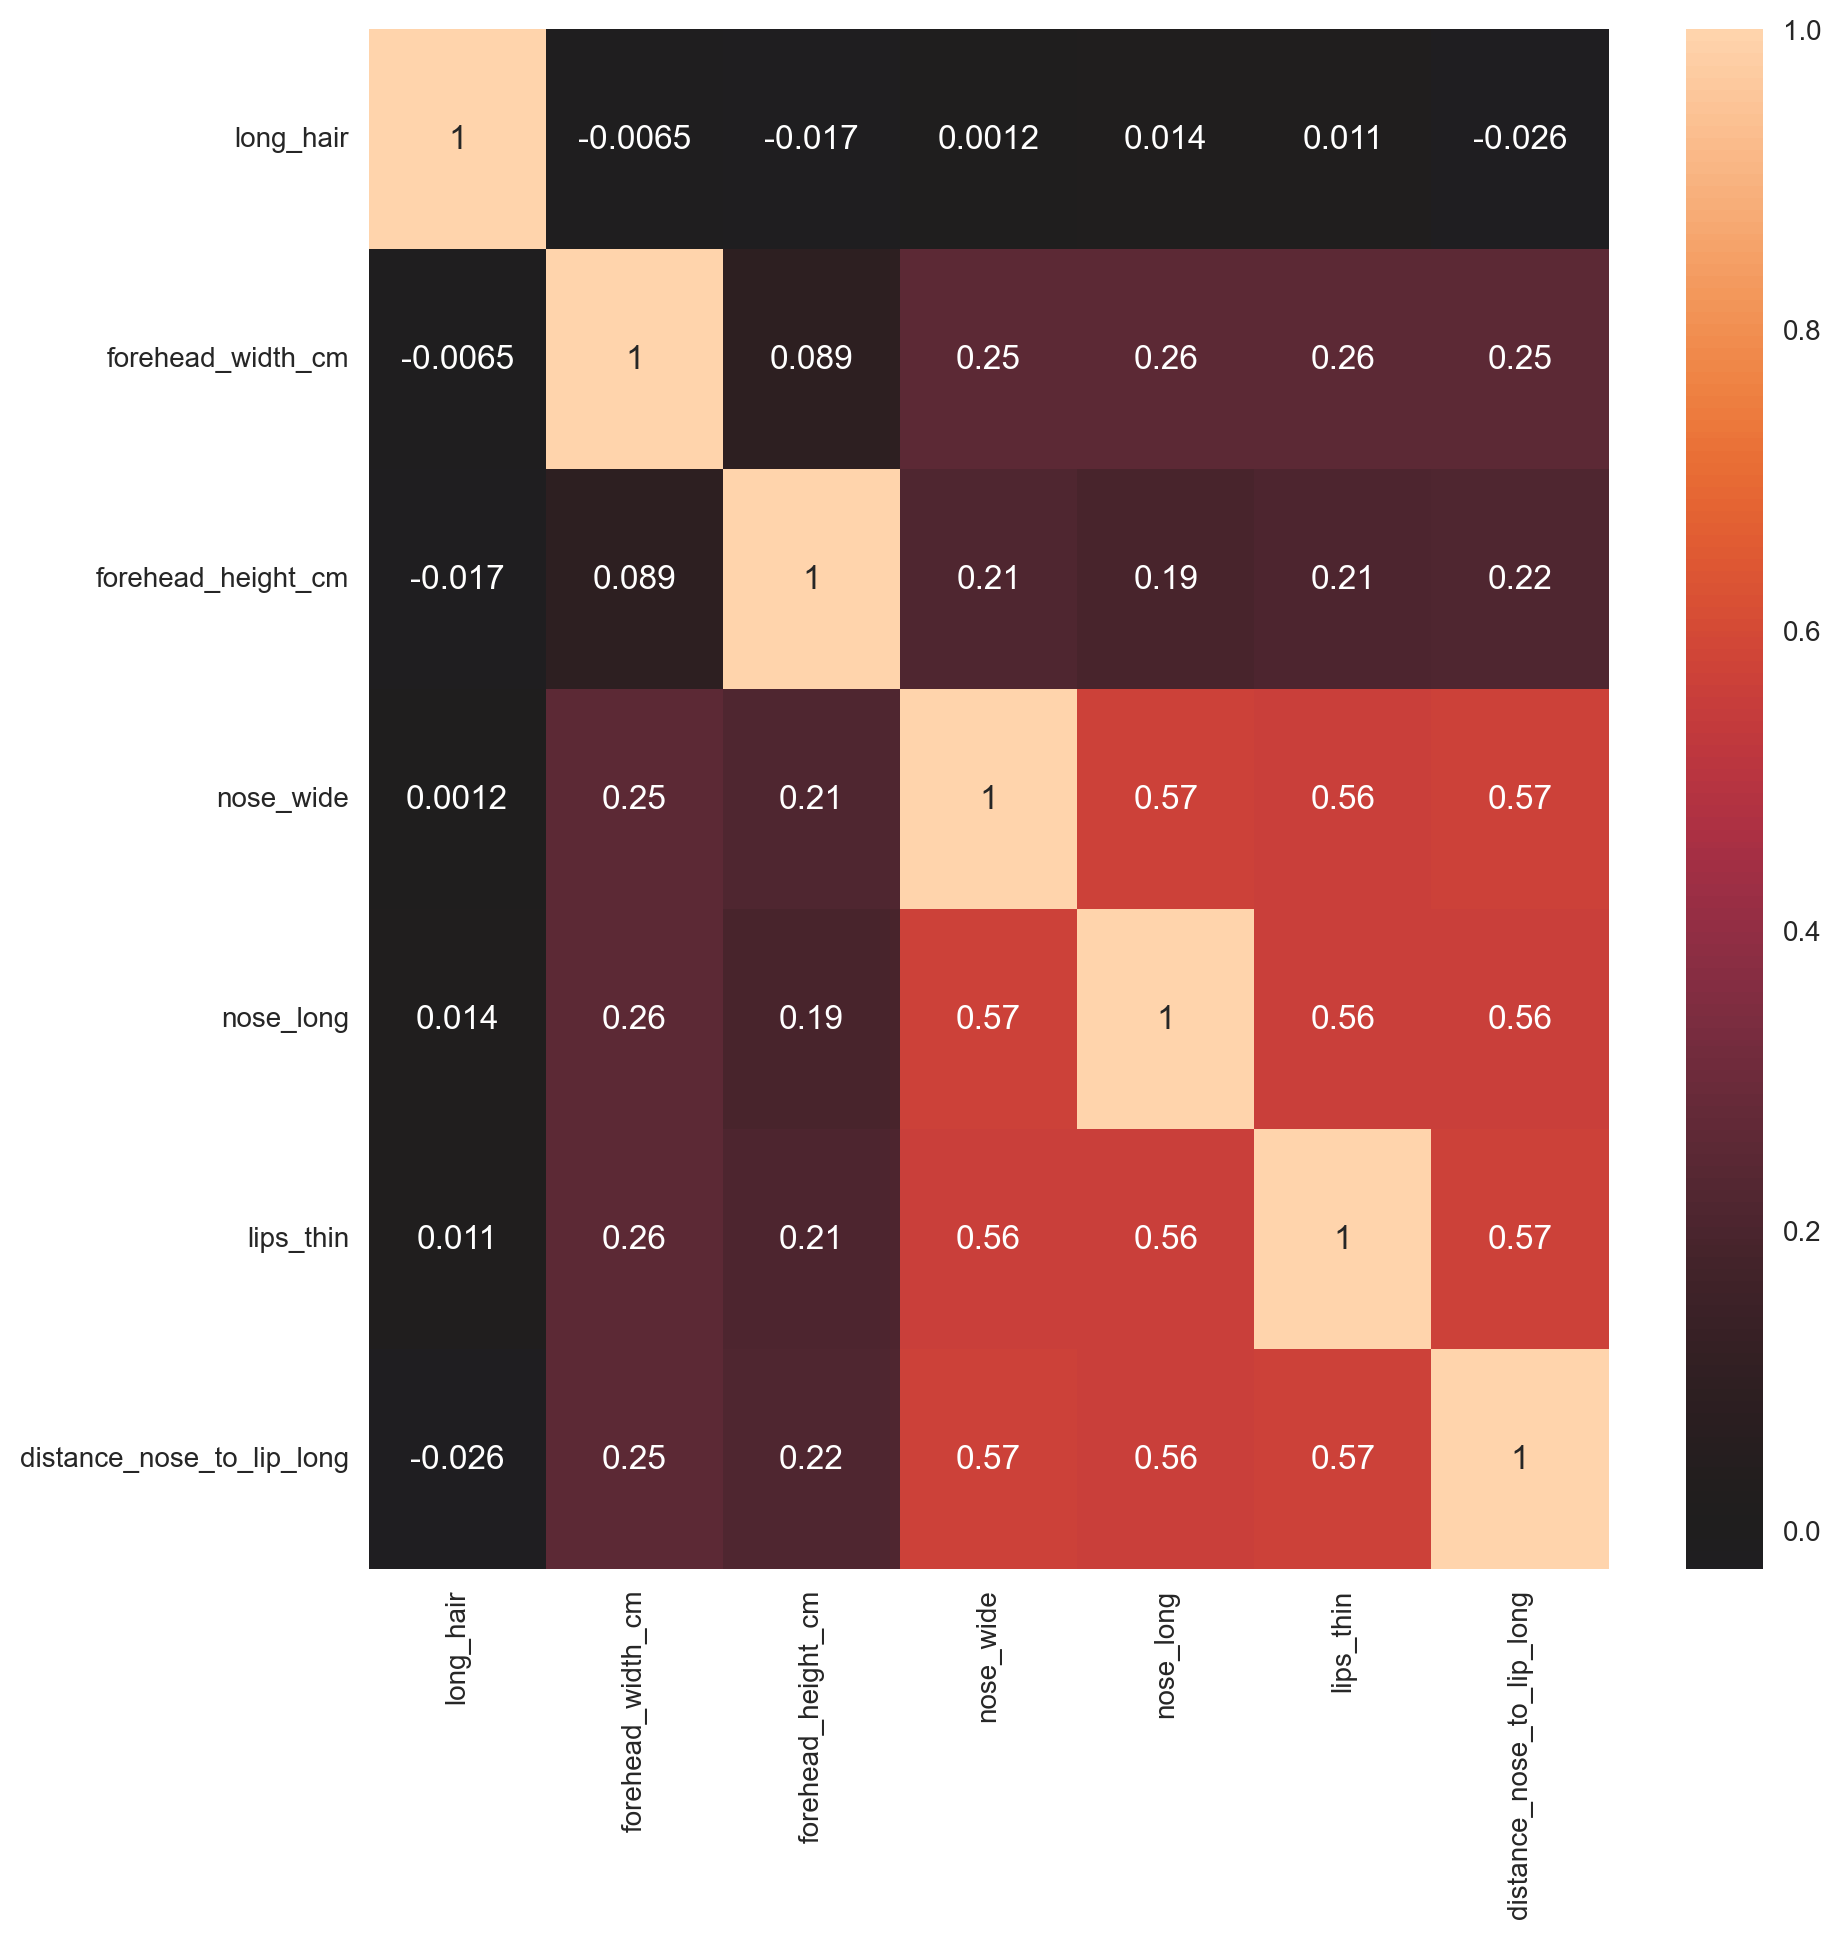

In [6]:
# See correlation matrix
corrmat = df.corr(numeric_only=True)
plt.figure(figsize=(10, 10))
sns.heatmap(corrmat, annot=True, center=0)

### Preprocessing

In [7]:
# Drop the label from the dataset
df_label = df['gender']
df.drop('gender', axis=1, inplace=True)
df.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long
0,1,11.8,6.1,1,0,1,1
1,0,14.0,5.4,0,0,1,0
2,0,11.8,6.3,1,1,1,1
3,0,14.4,6.1,0,1,1,1
4,1,13.5,5.9,0,0,0,0


In [8]:
# Specify the columns to check for outliers
columns_to_check = ['forehead_width_cm', 'forehead_height_cm']

# Initialize a dictionary to hold the number of outliers for each column
outlier_counts = {}

# Define a threshold for detecting outliers
threshold = 1.5

# Iterate over the specified columns
for column in columns_to_check:
    # Calculate percentiles for the specified column
    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    IQR = Q3 - Q1
    
    # Detect outliers using the IQR method
    outliers = (df[column] < (Q1 - threshold * IQR)) | (df[column] > (Q3 + threshold * IQR))
    
    # Store the number of outliers detected for the column
    outlier_counts[column] = np.sum(outliers)

# Print the number of outliers detected for each specified column
print("Number of outliers detected for each column:")
for column, count in outlier_counts.items():
    print(f"{column}: {count}")

Number of outliers detected for each column:
forehead_width_cm: 0
forehead_height_cm: 0


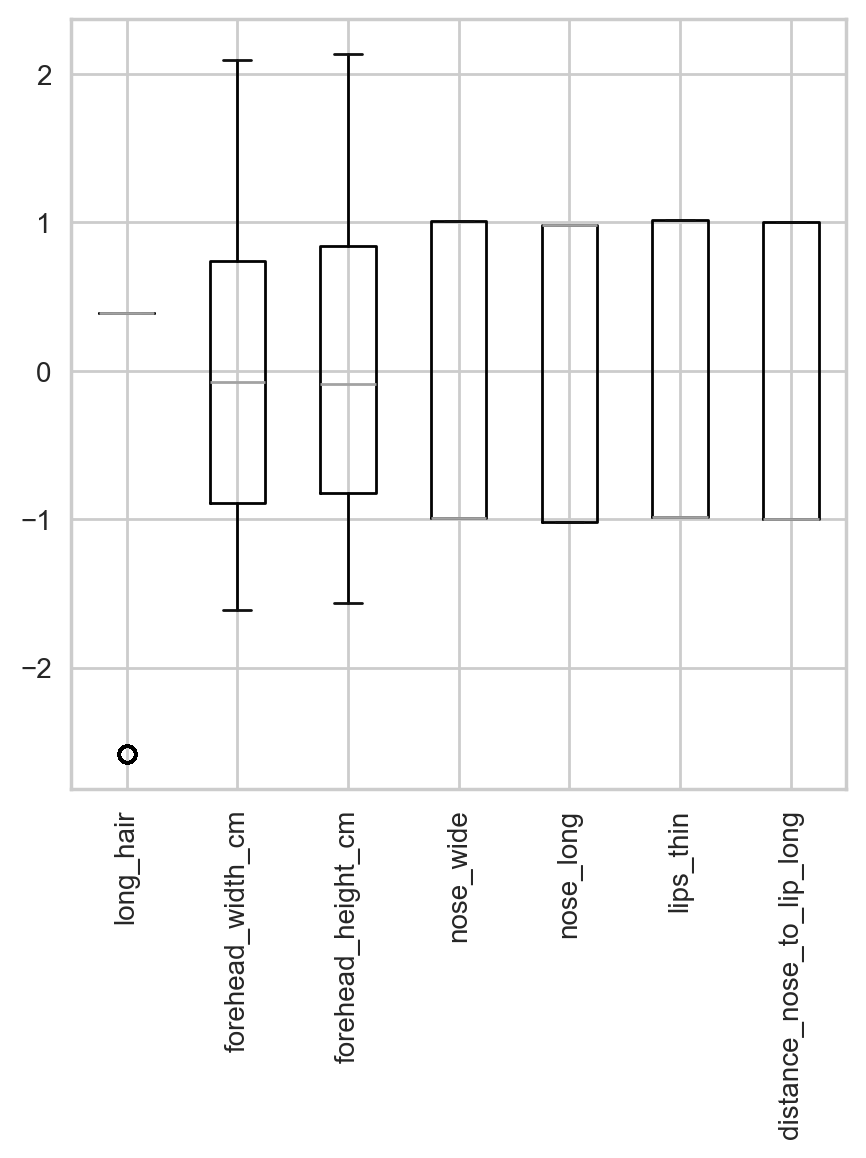

In [48]:
# Initialize the scaler
scaler = StandardScaler()

# Scale the specified columns
scaled_data = scaler.fit_transform(df)
scaled_data = pd.DataFrame(scaled_data, columns=df.columns)

# Plot the boxplot for the scaled data
scaled_data.boxplot(figsize=(5, 5))
plt.xticks(rotation=90)
plt.show()

Binary Data Characteristics: Binary data consists of only two possible values, typically 0 and 1. Each feature represents a simple categorical choice rather than a range of continuous values. Due to this limited scope, the concept of outliers—values that significantly deviate from the norm—is less applicable because there are no extreme values or large deviations in the data.

Standardization Purpose: Standardizing binary data before applying PCA helps in ensuring that each feature contributes equally to the analysis. Since binary data is often not centered (i.e., the mean can be different from zero) and the variance might be unequal among different features, standardization adjusts the data so that each feature has a mean of zero and a variance of one.

In [10]:
df = scaled_data
df

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long
0,0.387194,-1.247933,0.283971,1.012273,-1.015924,1.013894,1.002202
1,-2.582682,0.739389,-1.009418,-0.987876,-1.015924,1.013894,-0.997803
2,-2.582682,-1.247933,0.653511,1.012273,0.984326,1.013894,1.002202
3,-2.582682,1.100720,0.283971,-0.987876,0.984326,1.013894,1.002202
4,0.387194,0.287725,-0.085568,-0.987876,-1.015924,-0.986297,-0.997803
...,...,...,...,...,...,...,...
4996,0.387194,0.378057,-1.563727,-0.987876,-1.015924,-0.986297,-0.997803
4997,0.387194,-1.157600,-1.009418,-0.987876,-1.015924,-0.986297,-0.997803
4998,0.387194,-0.254272,-0.455108,-0.987876,-1.015924,-0.986297,-0.997803
4999,0.387194,0.016726,0.468741,-0.987876,-1.015924,-0.986297,-0.997803


In [11]:
def PCA_computation(X_scaled):
    # Calculate the covariance matrix of the scaled data
    covariance_matrix = np.cov(X_scaled, rowvar=False)
    
    # Compute eigenvalues and eigenvectors from the covariance matrix
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

    # Sort the eigenvalues and eigenvectors from high to low
    sorted_indices = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[sorted_indices]
    eigen_vectors = eigen_vectors[:, sorted_indices]

    # Calculate explained variances for each principal component
    explained_variances = np.array(eigen_values / np.sum(eigen_values) * 100)

    # Return the sorted eigenvalues, eigenvectors, and explained variances
    return eigen_values, eigen_vectors, explained_variances

In [12]:
eigen_values, eigen_vectors, explained_variances = PCA_computation(df)
print(explained_variances)
print(np.cumsum(explained_variances))

[41.76489235 14.35493226 13.08926211 12.0992442   6.3284135   6.27013717
  6.09311842]
[ 41.76489235  56.1198246   69.20908671  81.30833092  87.63674441
  93.90688158 100.        ]


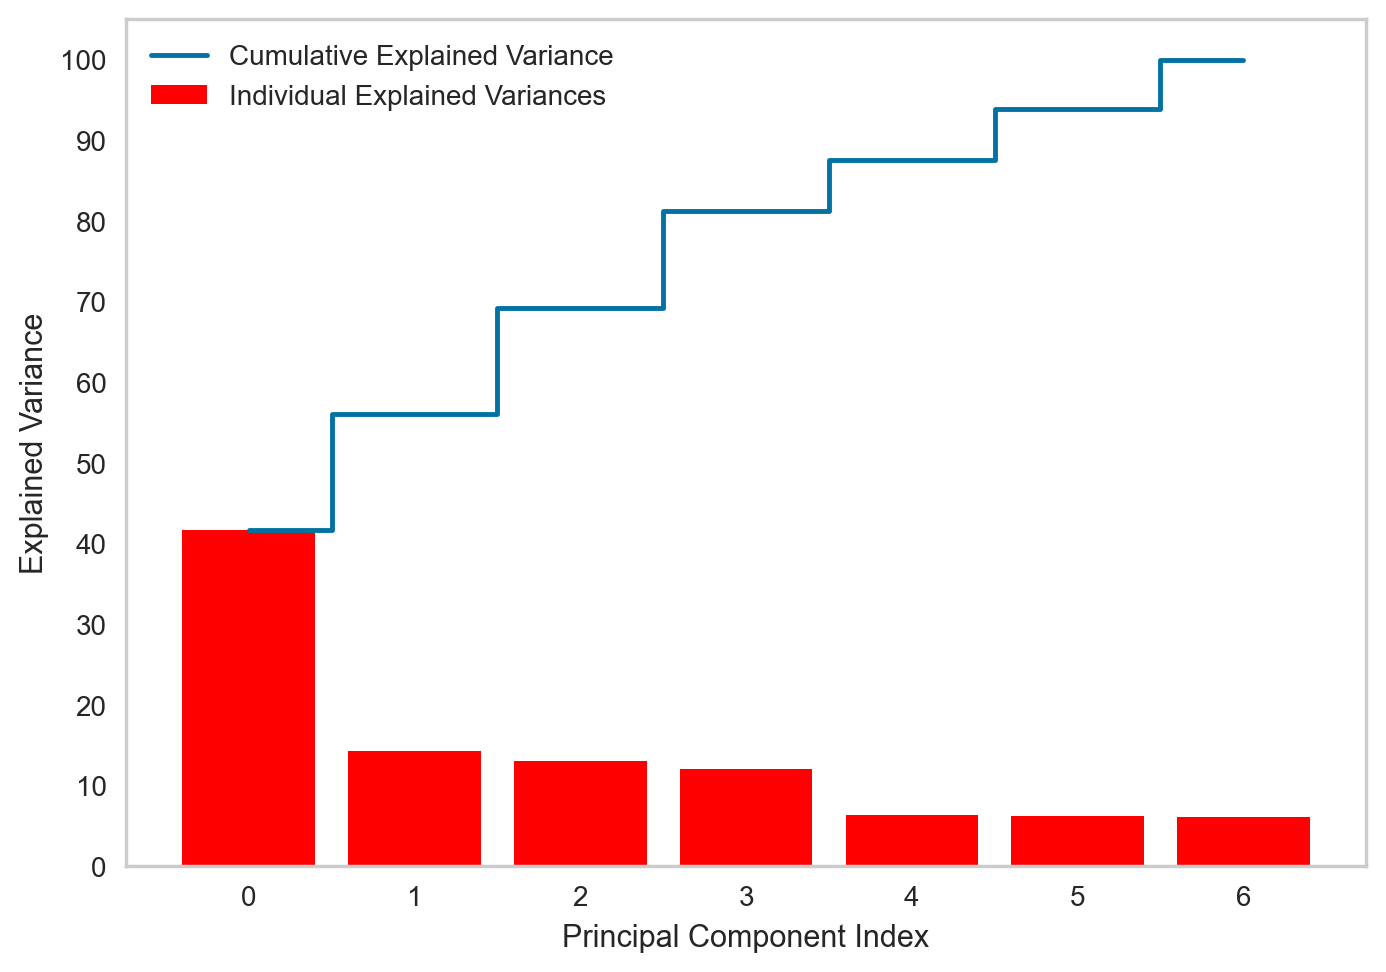

In [13]:
# Cumulative sum of explained variances for the y-axis
y_axis = np.cumsum(explained_variances)

# Create an array for the x-axis representing the index of principal components
x_axis = np.arange(len(y_axis))

# Plot the cumulative explained variances as a step plot
plt.step(y=y_axis, x=x_axis, where='mid')

# Plot individual explained variances as a bar chart
plt.bar(height=explained_variances, x=x_axis, color='red')
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance")

# Set the y-axis ticks from 0 to 100 with a step of 10
plt.yticks(np.arange(0, 110, 10))

plt.grid()
plt.legend(["Cumulative Explained Variance", "Individual Explained Variances"])
plt.show()

In [14]:
eigen_vectors

array([[ 2.55355780e-03, -9.83276518e-01, -1.53905324e-01,
        -8.00455486e-02, -3.30474706e-03, -4.56712168e-02,
        -3.11423890e-02],
       [-2.59288288e-01,  7.52213634e-04,  4.42389414e-01,
        -8.58350213e-01, -9.32236255e-03, -1.40021910e-02,
        -3.54529539e-03],
       [-2.14301636e-01,  1.67486783e-01, -8.79676266e-01,
        -3.88949064e-01, -2.63228907e-03,  2.99806684e-02,
        -2.34743510e-03],
       [-4.71519327e-01, -2.03848338e-02,  2.68933721e-02,
         1.65139830e-01, -5.47114482e-01, -3.27223862e-01,
         5.85533819e-01],
       [-4.69470211e-01, -4.90264699e-02,  5.97067617e-02,
         1.64652446e-01, -3.01206808e-01,  7.57151747e-01,
        -2.87253357e-01],
       [-4.70185348e-01, -3.96770264e-02,  4.08743884e-02,
         1.51176572e-01,  7.76972203e-01,  1.18351225e-01,
         3.67605202e-01],
       [-4.72261428e-01,  2.68607194e-02,  2.85579822e-02,
         1.68256653e-01,  7.84196489e-02, -5.49961818e-01,
        -6.6220400

In [15]:
number_of_components = 3
df_clustering = np.matmul(df, eigen_vectors[:, :number_of_components])
df_clustering

,0,1,2
0,-0.686672,-0.318233,-0.824837
1,0.955264,2.373897,1.538269
2,-1.712506,2.565805,-0.573405
3,-1.299183,2.546451,0.736899
4,1.822437,-0.312558,-0.013067
...,...,...,...
4996,2.115787,-0.560062,1.327197
4997,2.395175,-0.468378,0.160225
4998,2.042163,-0.374859,0.072235
4999,1.773914,-0.219922,-0.620567


#### K-Means Clustering

In [16]:
def compute_silhouette_coef(df: pd.DataFrame, k_lower: int, k_upper: int):
    print("Comparison of silhouette coefficient for different k values:")
    for k in range(k_lower, k_upper+1):
        # Defining the K-Means model with a specific k value
        clusterer = KMeans(n_clusters=k)

        # Get cluster label for each data points in df
        cluster_labels = clusterer.fit_predict(df)

        # Calculating silhouette_score to measure how well the clusters are formed
        silhouette_avg = silhouette_score(df, cluster_labels)
        print(
            f"For k = {k}, the average silhouette coefficient is: {silhouette_avg}"
        )

In [17]:
len = 9
compute_silhouette_coef(df_clustering, 2, len)

Comparison of silhouette coefficient for different k values:
For k = 2, the average silhouette coefficient is: 0.4808536423448045
For k = 3, the average silhouette coefficient is: 0.5219782766998929
For k = 4, the average silhouette coefficient is: 0.46591846356370026
For k = 5, the average silhouette coefficient is: 0.49121270008969187
For k = 6, the average silhouette coefficient is: 0.4102181588764253
For k = 7, the average silhouette coefficient is: 0.41448460995127434
For k = 8, the average silhouette coefficient is: 0.3913568880942517
For k = 9, the average silhouette coefficient is: 0.38658438204600465


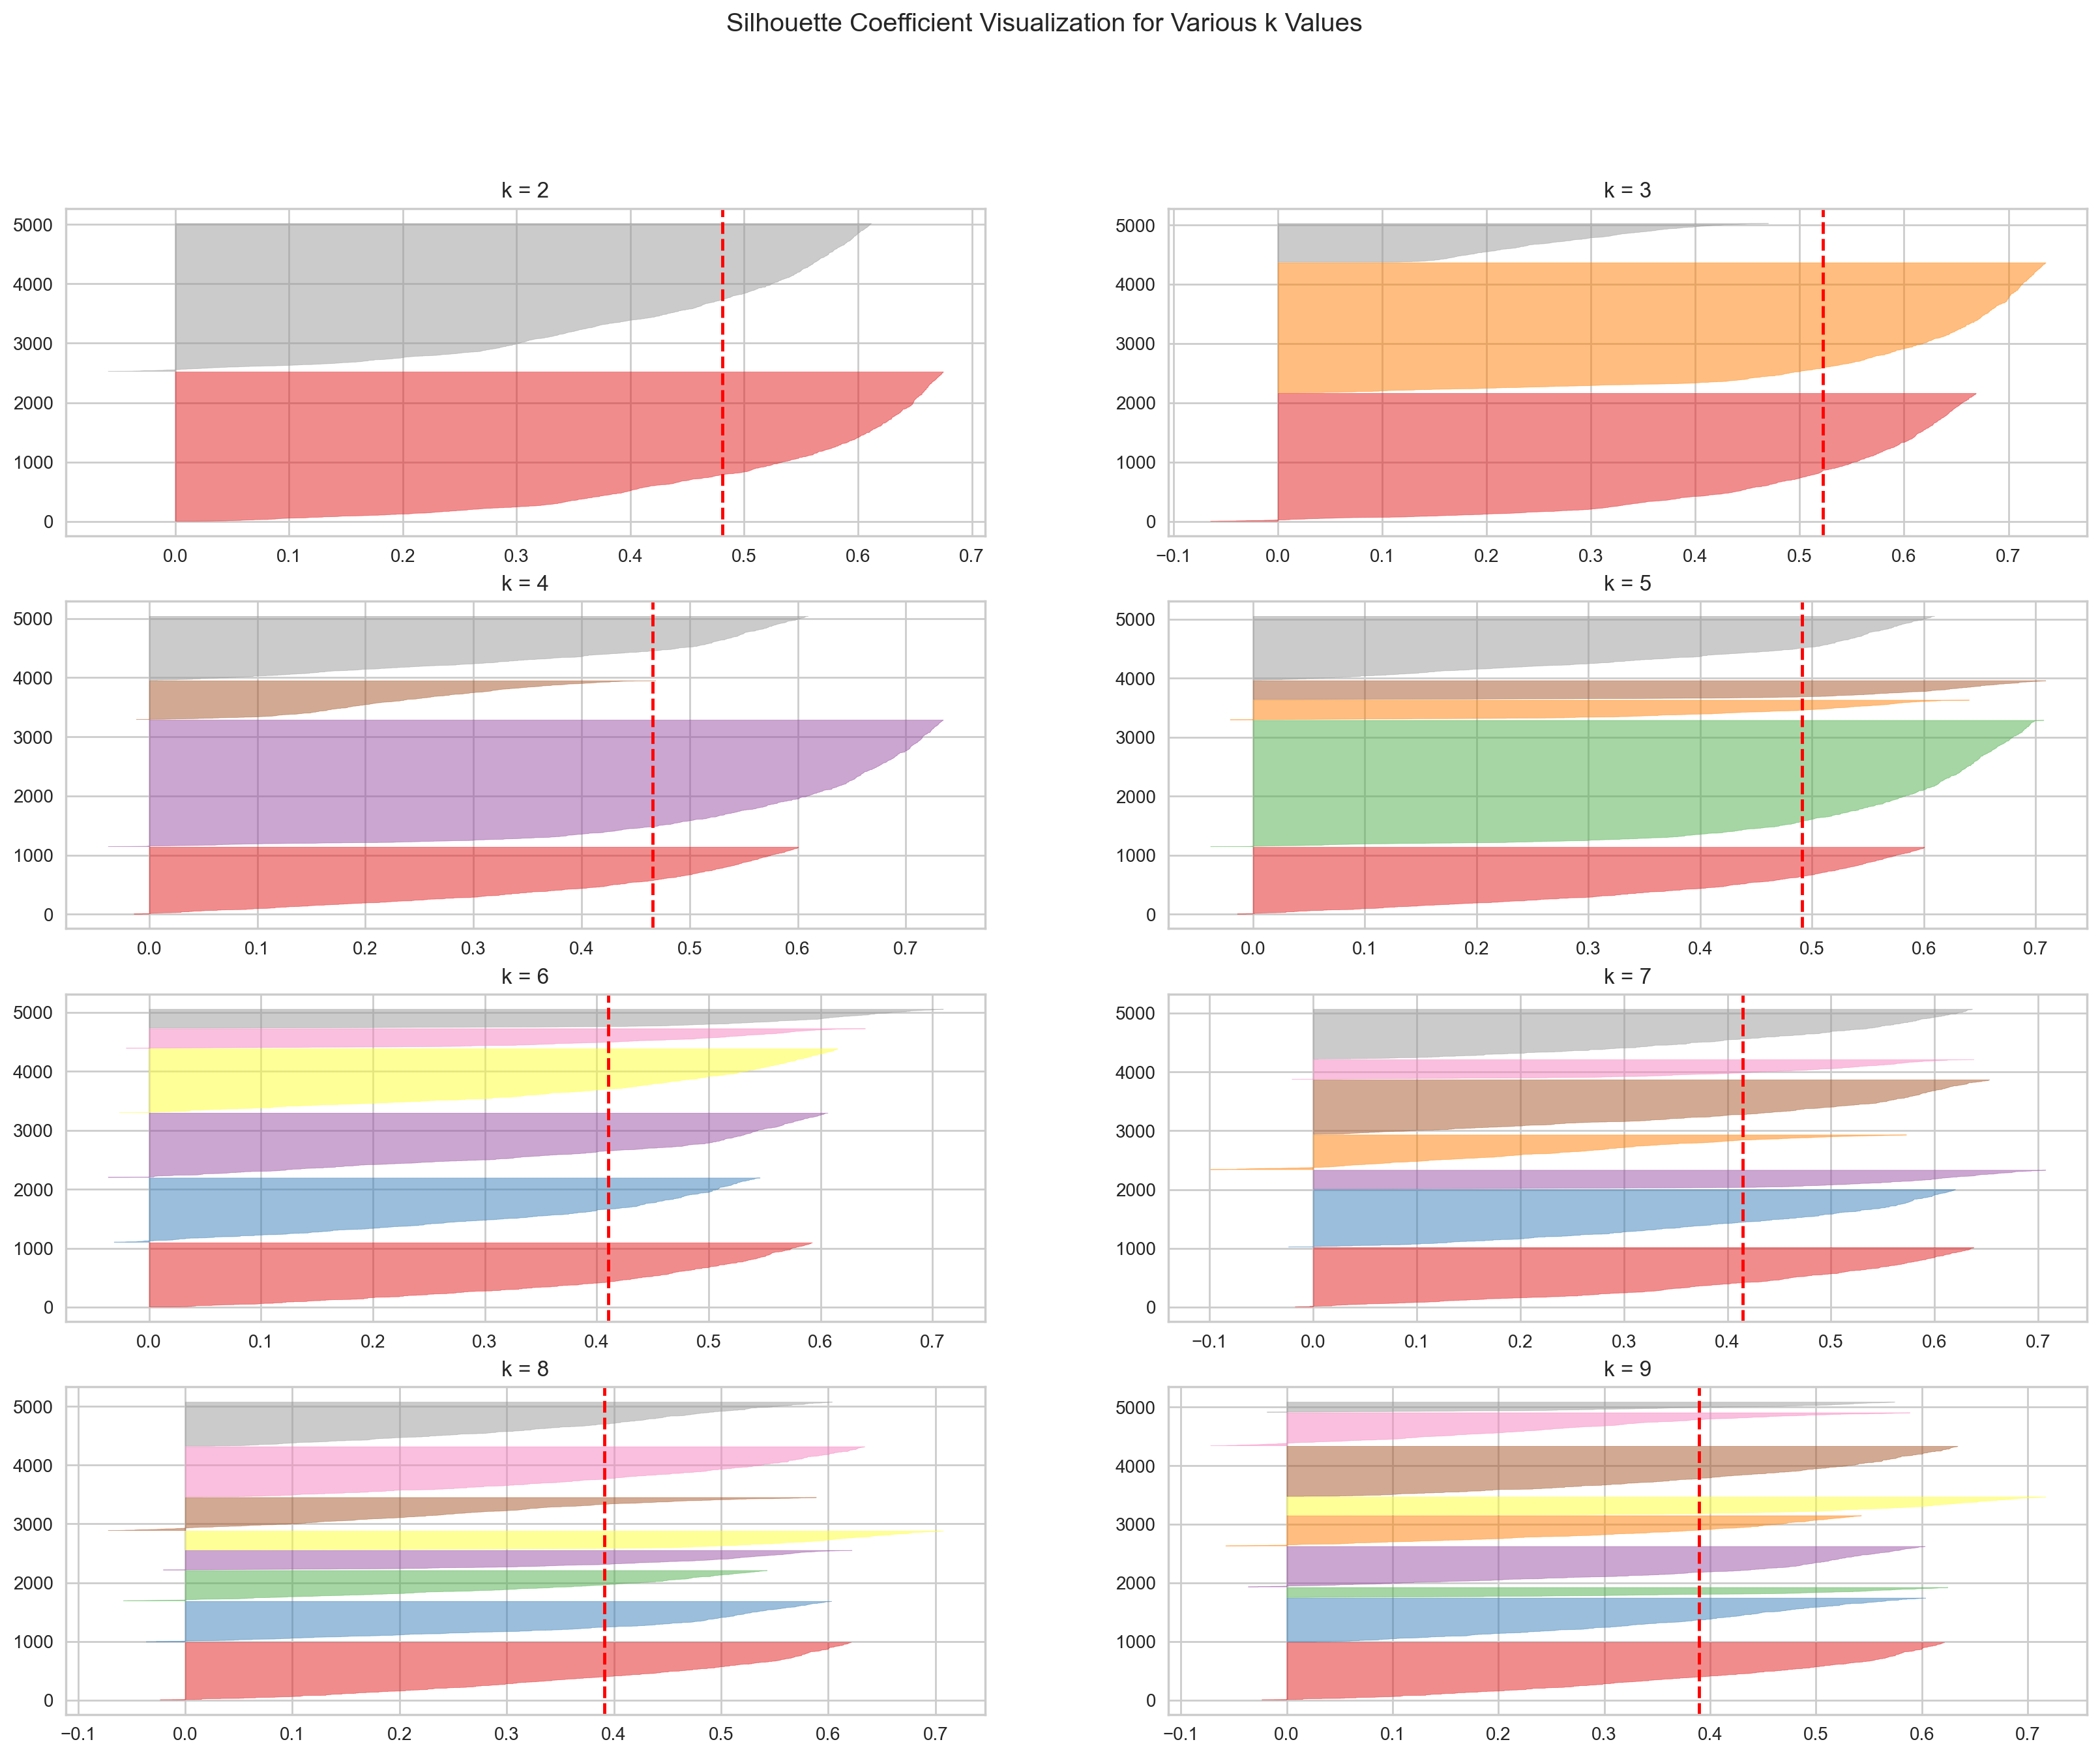

In [18]:
fig, ax = plt.subplots(4, 2, figsize=(20,15))
fig.suptitle("Silhouette Coefficient Visualization for Various k Values")
for k in range(2, len + 1):
    # Define K-Means model with a specific value of k
    clusterer = KMeans(n_clusters=k)

    # Visualize the density of each cluster formed
    q, mod = divmod(k, 2)
    ax[q-1][mod].set_title(f"k = {k}")
    visualizer = SilhouetteVisualizer(clusterer, ax=ax[q-1][mod])
    visualizer.fit(df_clustering)

The value k = 3 is the most optimal because it yields the highest score, approximately 0.52 for the silhouette coefficient. However, this value indicates that there is one cluster that is narrow and weak. Additionally, the clusters for k = 3 have two wide and well-separated silhouettes, which indicates well-defined clusters, and each cluster exceeds its average (surpassing the vertical red line).

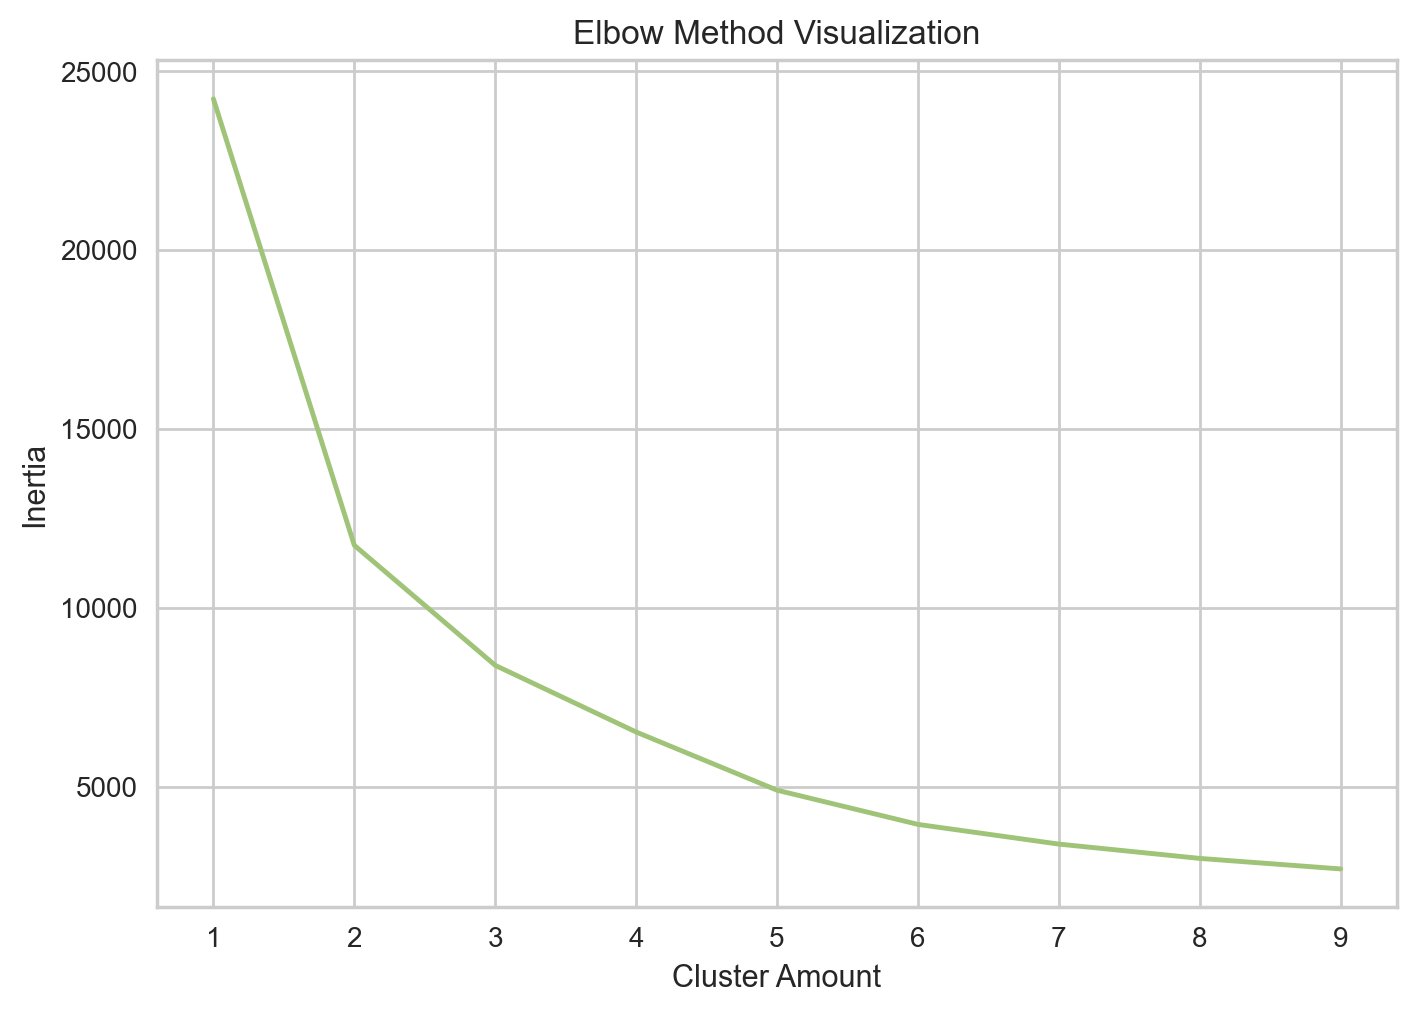

In [19]:
# Initialize an empty list to store inertia values
inertia = []

# Loop over a range of cluster numbers from 1 to len (inclusive)
for cluster in range(1, len + 1):
    # Create a KMeans model with the current number of clusters
    km = KMeans(n_clusters=cluster)
    
    # Fit the KMeans model to the data
    km = km.fit(df_clustering)
    
    # Append the inertia (sum of squared distances to nearest cluster center) to the list
    inertia.append(km.inertia_)

# Plot the inertia values against the number of clusters
plt.plot(range(1, len + 1), inertia, 'gx-')
plt.xlabel('Cluster Amount')  # Label for the x-axis
plt.ylabel('Inertia')         # Label for the y-axis
plt.title('Elbow Method Visualization')  # Title of the plot
plt.show()  # Display the plot

In the elbow method visualization, the main goal is to find the lowest inertia with a minimal number of clusters. From the graph, the elbow point occurs when the number of clusters is 3. In the silhouette method, the optimal number of clusters is often evident directly from the value of k that results in the highest silhouette coefficient. However, in the elbow method, we need to estimate from the graph. Choose the point where the line after it appears to be linear. This value could be 3, 5, or 7. Therefore, we can agree on 3 as it aligns with both the silhouette method and the elbow method.

In [20]:
kmeans = KMeans(n_clusters=3)
cluster_kmeans= kmeans.fit_predict(df_clustering)

In [21]:
# Append result of clustering to Dataframe
df_with_clusters = pd.DataFrame(df_clustering.copy())
df_with_clusters['cluster'] = cluster_kmeans
df_with_clusters

,0,1,2,cluster
0,-0.686672,-0.318233,-0.824837,1
1,0.955264,2.373897,1.538269,2
2,-1.712506,2.565805,-0.573405,2
3,-1.299183,2.546451,0.736899,2
4,1.822437,-0.312558,-0.013067,0
...,...,...,...,...
4996,2.115787,-0.560062,1.327197,0
4997,2.395175,-0.468378,0.160225,0
4998,2.042163,-0.374859,0.072235,0
4999,1.773914,-0.219922,-0.620567,0


In [22]:
feature1 = 0
feature2 = 1
feature3 = 2

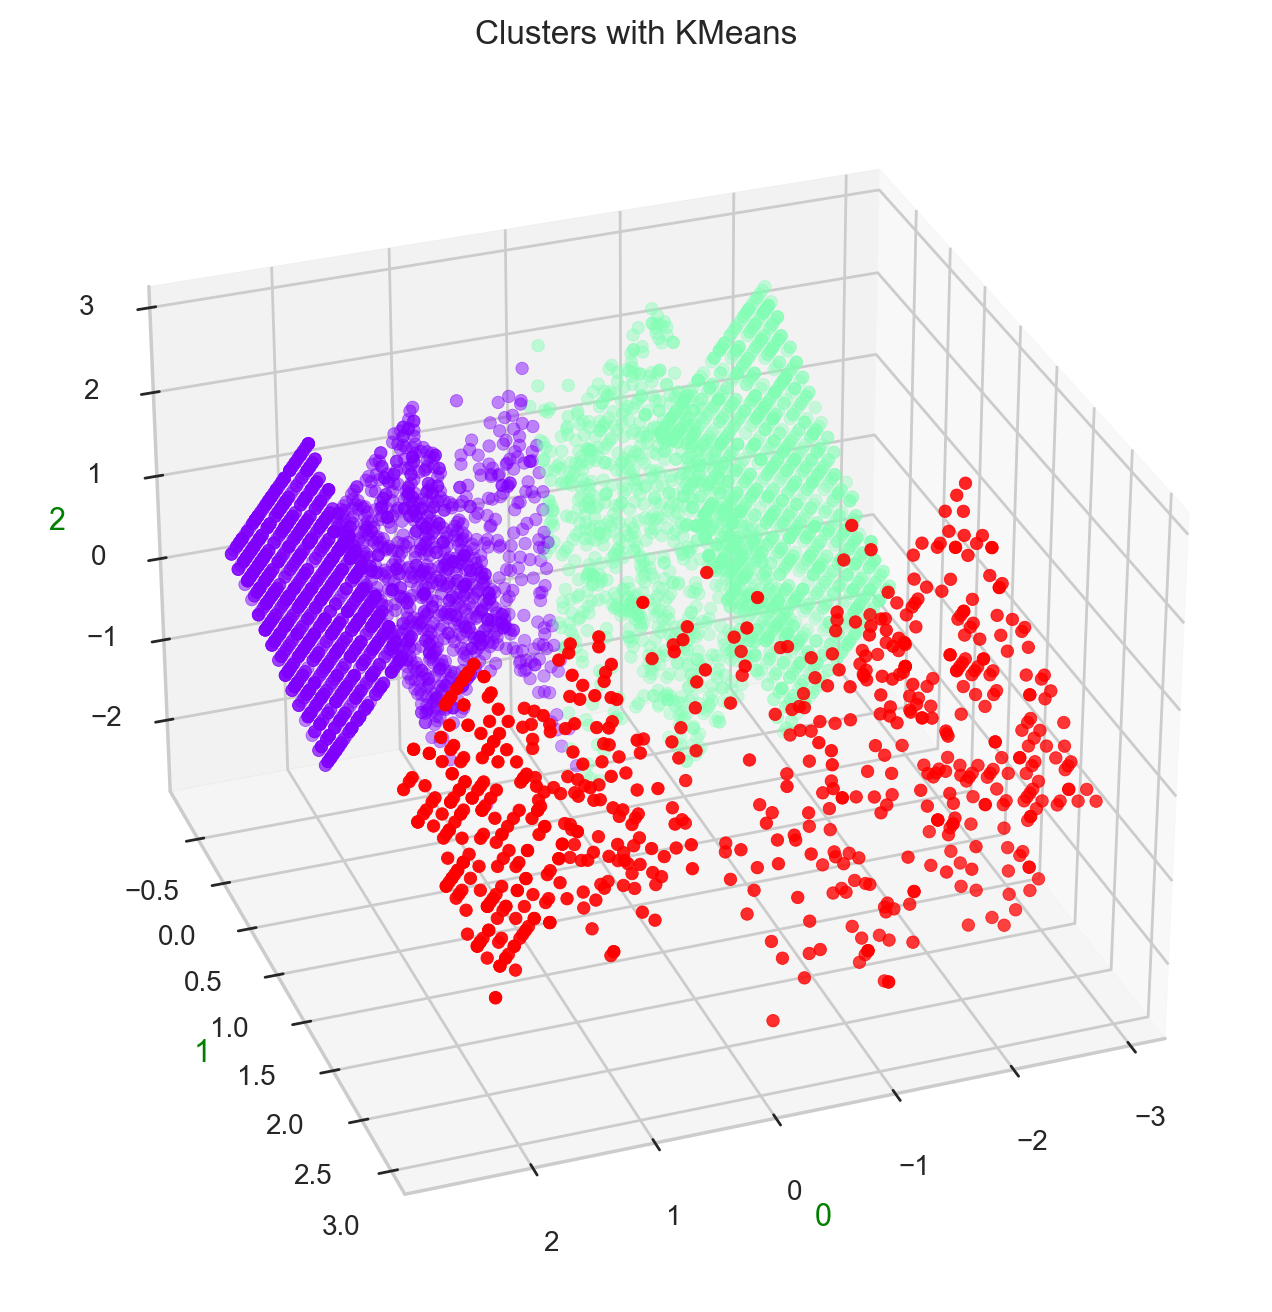

In [46]:
# Create a new figure for the 3D plot with a specified size
fig = plt.figure(figsize=(8, 8))

# Add a 3D subplot to the figure
ax = plt.axes(projection="3d")

# Extract the data for each axis from the DataFrame
x = df_with_clusters[feature1]  # Data for the x-axis
y = df_with_clusters[feature2]  # Data for the y-axis
z = df_with_clusters[feature3]  # Data for the z-axis
cluster = df_with_clusters['cluster']  # Data for coloring the points based on cluster assignment

# Create a 3D scatter plot with the data
# `c=cluster` colors the points based on their cluster assignment
# `cmap="rainbow"` specifies the colormap used for coloring the clusters
ax.scatter(x, y, z, c=cluster, cmap="rainbow")

# Set the title of the plot
plt.title("Clusters with KMeans")

# Disable the grid lines in the plot
plt.grid(False)

# Adjust the viewing angle
ax.view_init(elev=30, azim=70)

# Set labels for the x, y, and z axes with green color
ax.set_xlabel(f'{feature1}', color='green')
ax.set_ylabel(f'{feature2}', color='green')
ax.set_zlabel(f'{feature3}', color='green')

plt.show()

#### Hierarchichal Clustering

In [24]:
# Membuat model sementara untuk divisualisasikan
agglomerative = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')
cluster_agglomerative = agglomerative.fit(df_clustering)

# Menampilkan label klaster tiap data points
cluster_agglomerative.labels_

array([5000, 3745, 4999, ...,    2,    1,    0], dtype=int64)

In [25]:
(agglomerative.labels_).size

5001

In [26]:
agglomerative.children_

array([[   0,  923],
       [   2, 1773],
       [   6, 1901],
       ...,
       [9993, 9997],
       [9995, 9996],
       [9998, 9999]])

In [27]:
agglomerative.children_.shape[0]

5000

In [28]:
def plot_dendrogram(model, **kwargs):
    # Initialize an array to store the count of samples in each cluster
    counts = np.zeros(model.children_.shape[0])
    
    # Get the total number of samples in the dataset
    n_samples = (model.labels_).size
    
    # Iterate over the merges (clusters) in the hierarchical clustering model
    for i, merge in enumerate(model.children_):
        current_count = 0
        
        # Count the number of samples in the cluster formed by this merge
        for child_idx in merge:
            if child_idx < n_samples:
                # Leaf node (individual sample)
                current_count += 1
            else:
                # Non-leaf node (cluster of samples)
                current_count += counts[child_idx - n_samples]
        
        # Store the count of samples for the current merge
        counts[i] = current_count
    
    # Create a linkage matrix with information needed to plot the dendrogram
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    
    # Plot the dendrogram using the linkage matrix and additional arguments
    shc.dendrogram(linkage_matrix, **kwargs)

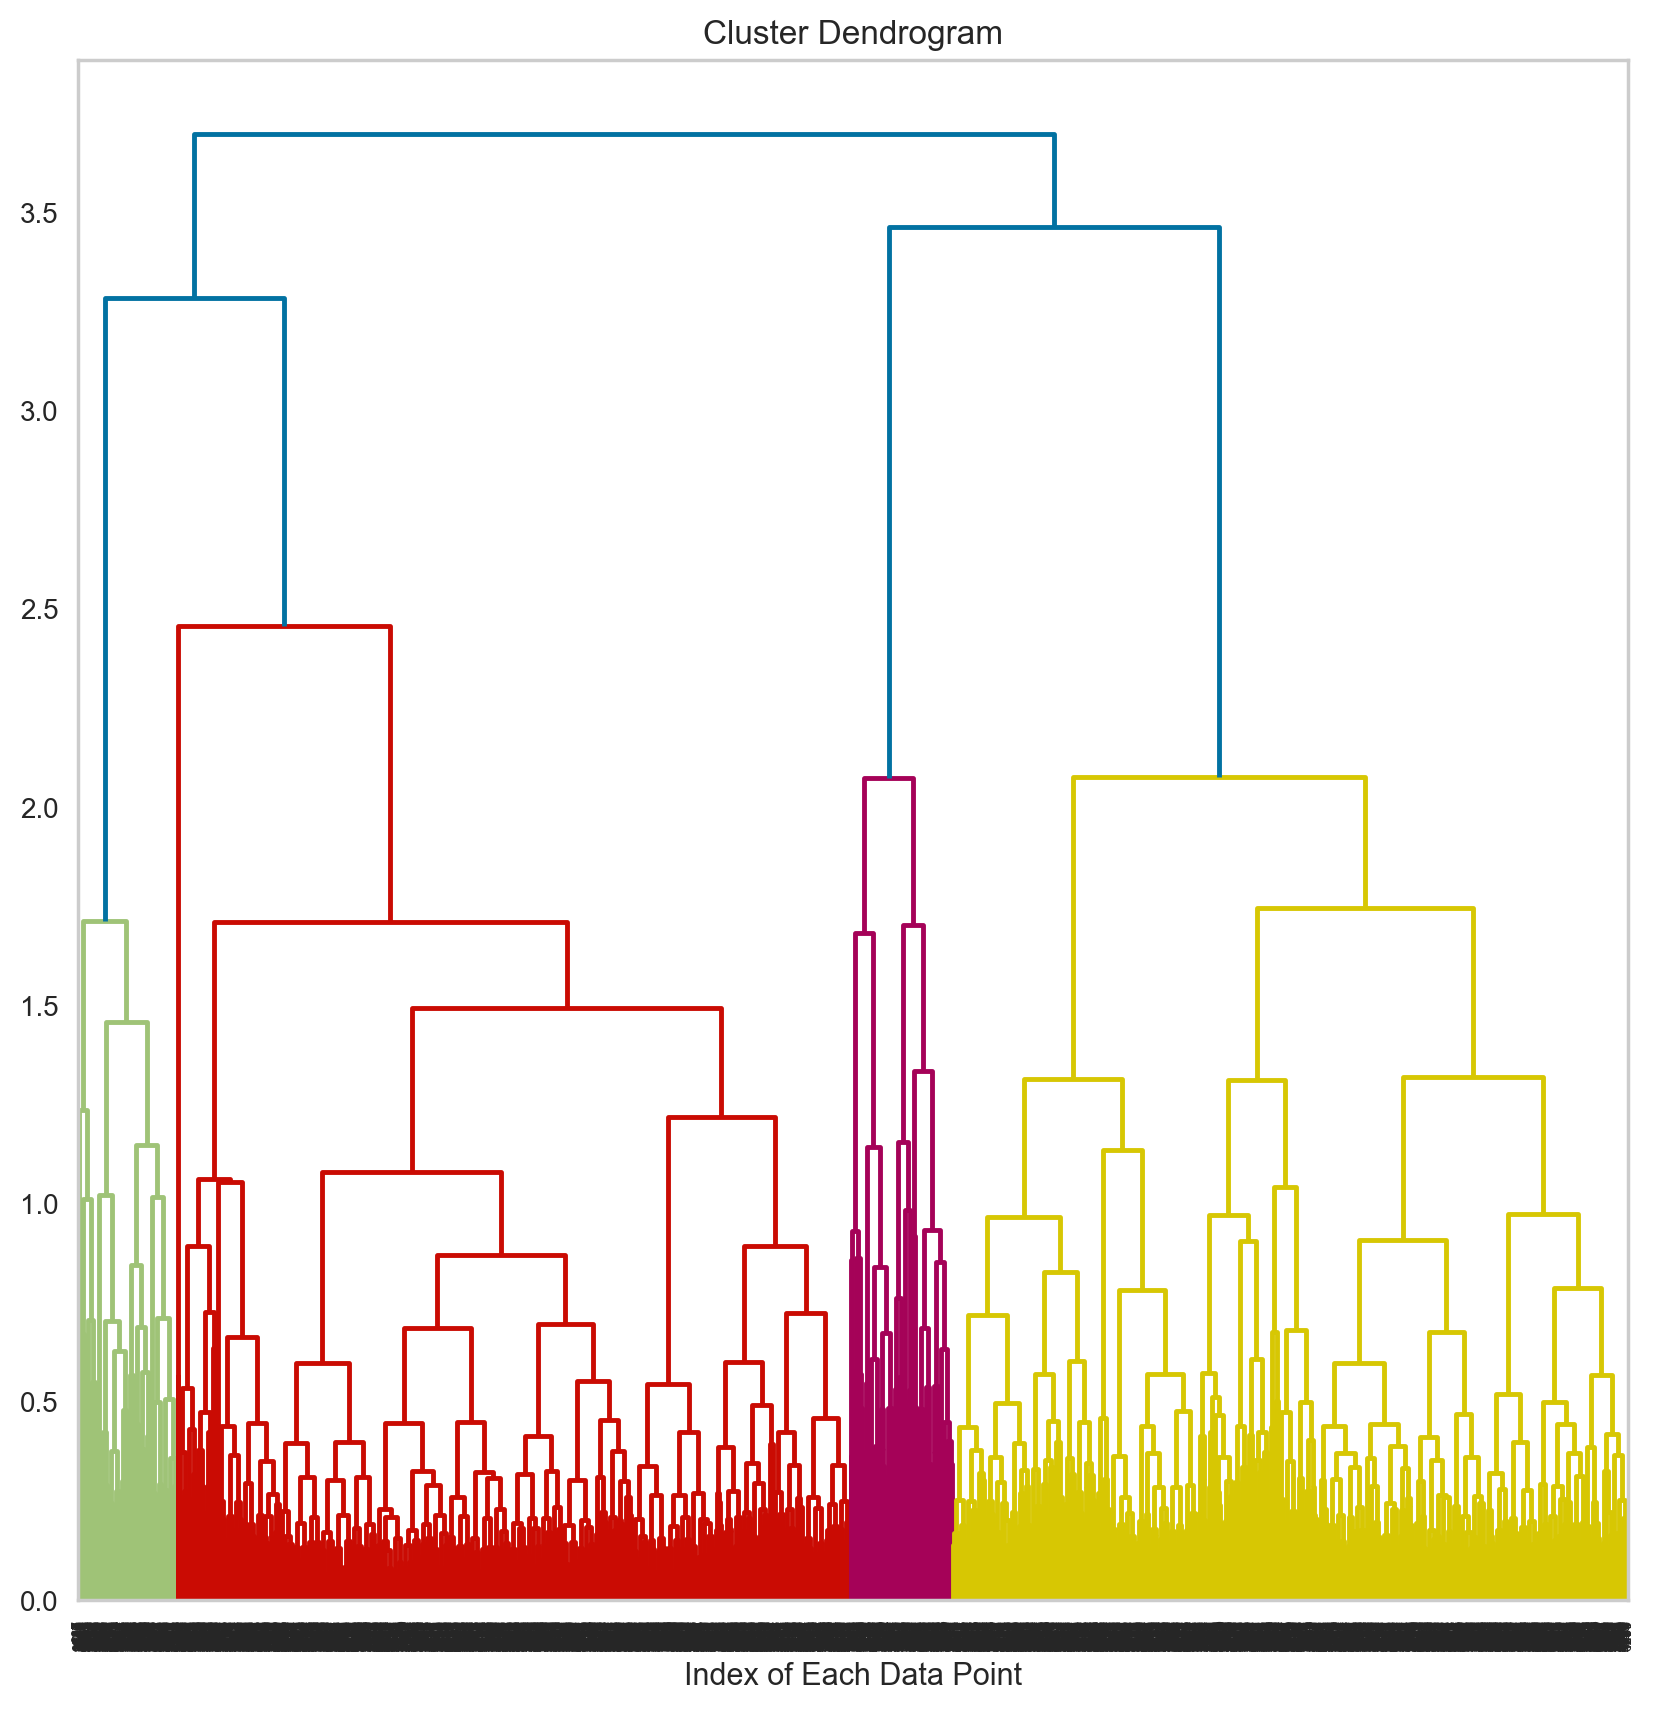

In [29]:
plt.figure(figsize=(10, 10))
plt.grid(False)
plot_dendrogram(agglomerative, truncate_mode=None)
plt.title("Cluster Dendrogram")
plt.xlabel("Index of Each Data Point")
plt.show()

From the dendrogram above, the optimal number of clusters is 2, which matches the result from K-Means. There are two methods to determine the optimal number of clusters from a dendrogram in Python:
1. Manual Method: This involves identifying the longest vertical line in the dendrogram. In the dendrogram result, the longest vertical line is shown in blue. A horizontal line can be drawn across this longest vertical line to set a threshold, which gives the optimal number of clusters as 4.
2. Automatic Method in Python: Python automatically visualizes branches with significant differences using different colors. In the result above, there are five colors: blue, green, red, purple, and yellow. The optimal number of clusters is determined by counting the number of colors excluding the main branch color (blue) or by counting the number of colors minus one. Therefore, the result is 5-1 = 4 clusters.

In [30]:
# Define the model with the previous visualization results
agglomerative = AgglomerativeClustering(n_clusters=4, linkage='average')
cluster_agglomerative = agglomerative.fit_predict(df_clustering)

In [31]:
df_with_agglomerative = pd.DataFrame(df_clustering.copy())
df_with_agglomerative['cluster'] = cluster_agglomerative
df_with_agglomerative

,0,1,2,cluster
0,-0.686672,-0.318233,-0.824837,1
1,0.955264,2.373897,1.538269,3
2,-1.712506,2.565805,-0.573405,2
3,-1.299183,2.546451,0.736899,2
4,1.822437,-0.312558,-0.013067,0
...,...,...,...,...
4996,2.115787,-0.560062,1.327197,0
4997,2.395175,-0.468378,0.160225,0
4998,2.042163,-0.374859,0.072235,0
4999,1.773914,-0.219922,-0.620567,0


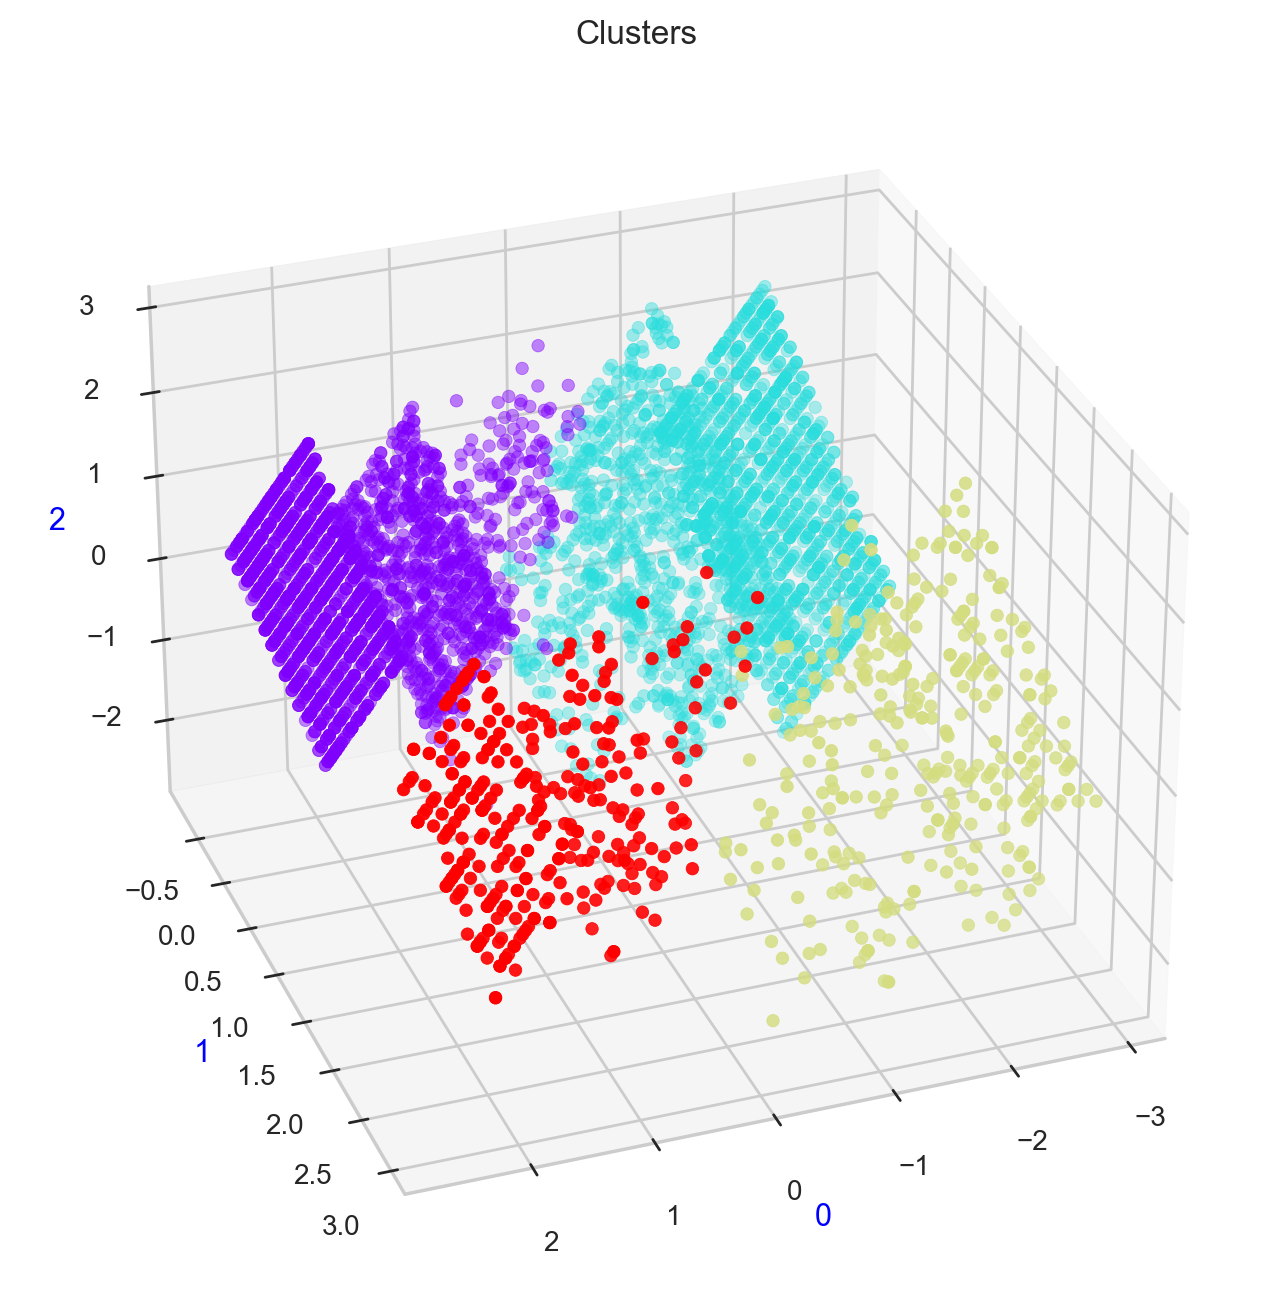

In [47]:
# Create a figure for the 3D plot with a size of 8x8 inches
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection="3d")  # Create 3D axes for the plot

# Prepare several variables needed for visualization
x = df_with_agglomerative[feature1]  # X-axis data from the first feature
y = df_with_agglomerative[feature2]  # Y-axis data from the second feature
z = df_with_agglomerative[feature3]  # Z-axis data from the third feature
cluster = df_with_agglomerative['cluster']  # Cluster labels to color the points

# Visualize the results with a 3D scatter plot
ax.scatter(x, y, z, c=cluster, cmap="rainbow")  # Scatter plot with points colored by cluster
plt.title("Clusters")  # Set the title of the plot
plt.grid(False)  # Disable the grid for a cleaner look

# Adjust the viewing angle
ax.view_init(elev=30, azim=70)

# Set labels for the x, y, and z axes with green color
ax.set_xlabel(f'{feature1}', color='blue')
ax.set_ylabel(f'{feature2}', color='blue')
ax.set_zlabel(f'{feature3}', color='blue')

plt.show()

In the plot above, four distinct clusters are shown in different colors: red, yellow, blue, and purple, each representing a separate group of data points. Hierarchical clustering creates a tree-like diagram called a dendrogram to illustrate how clusters are formed by grouping similar data points together. This plot is based on PCA (Principal Component Analysis), which reduces the data to three dimensions for easier visualization.

Hierarchical clustering builds a hierarchy of clusters, allowing you to see how clusters merge or split, and you don't need to specify the number of clusters in advance. However, it can be slow with large datasets because it calculates distances between all pairs of data points. On the other hand, K-Means clustering divides the data into a predefined number of clusters `k` by minimizing the differences within each cluster. It’s faster and more efficient for larger datasets but requires you to decide how many clusters you want beforehand. Thus, hierarchical clustering helps explore data structure, while K-Means is quicker and suitable for large datasets when the number of clusters is known.

#### Measuring Clustering Quality

In [33]:
def purity_score(y_true, y_pred):
    # Compute the contingency matrix (also called confusion matrix)
    confusion_matrix = contingency_matrix(y_true, y_pred)
    # Return the purity score
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)

In [44]:
distance_measures = {'euclidean': 0, 'minkowski': 4, 'chi-square': 6}
X = df_clustering.iloc[:, :].values
y = pd.read_csv('gender.csv').iloc[:, -1].values

# Function defined to compute purity score using pyclustering for various distance measures
def pyPurity(dist_measure):
    initial_centers = random_center_initializer(X, 2, random_state=12).initialize()
    
    # Create an instance of k-means with the respective distance metric
    if dist_measure == 0:
        instanceKm = kmeans(X, initial_centers=initial_centers, metric=distance_metric(type_metric.EUCLIDEAN))
    elif dist_measure == 4:
        instanceKm = kmeans(X, initial_centers=initial_centers, metric=distance_metric(type_metric.MINKOWSKI, degree=4))
    elif dist_measure == 6:
        instanceKm = kmeans(X, initial_centers=initial_centers, metric=distance_metric(type_metric.CHI_SQUARE))
    
    # Perform cluster analysis
    instanceKm.process()
    
    # Get the clusters and centers from the clustering results
    pyClusters = instanceKm.get_clusters()
    
    # Encode the clusters to get labels
    pyEncoding = instanceKm.get_cluster_encoding()
    pyEncoder = cluster_encoder(pyEncoding, pyClusters, X)
    pyLabels = pyEncoder.set_encoding(0).get_clusters()
    
    # Compute and return the purity score (function defined previously)
    return purity_score(y, pyLabels)

# Print the results
for measure, value in distance_measures.items():
    print(f"The purity score for {measure} distance is {round(pyPurity(value) * 100, 2)}%")

The purity score for euclidean distance is 96.82%
The purity score for minkowski distance is 96.84%
The purity score for chi-square distance is 96.86%


#### Analyse Gender - K-Means Clustering

In [53]:
df1 = pd.read_csv('gender.csv')

# Combine `df1` with `cluster_series` into a new DataFrame
df_combined1 = pd.concat([df1, df_with_clusters['cluster']], axis=1)

# Display the first few rows of the combined DataFrame
df_combined1.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender,cluster
0,1,11.8,6.1,1,0,1,1,Male,1
1,0,14.0,5.4,0,0,1,0,Female,2
2,0,11.8,6.3,1,1,1,1,Male,2
3,0,14.4,6.1,0,1,1,1,Male,2
4,1,13.5,5.9,0,0,0,0,Female,0


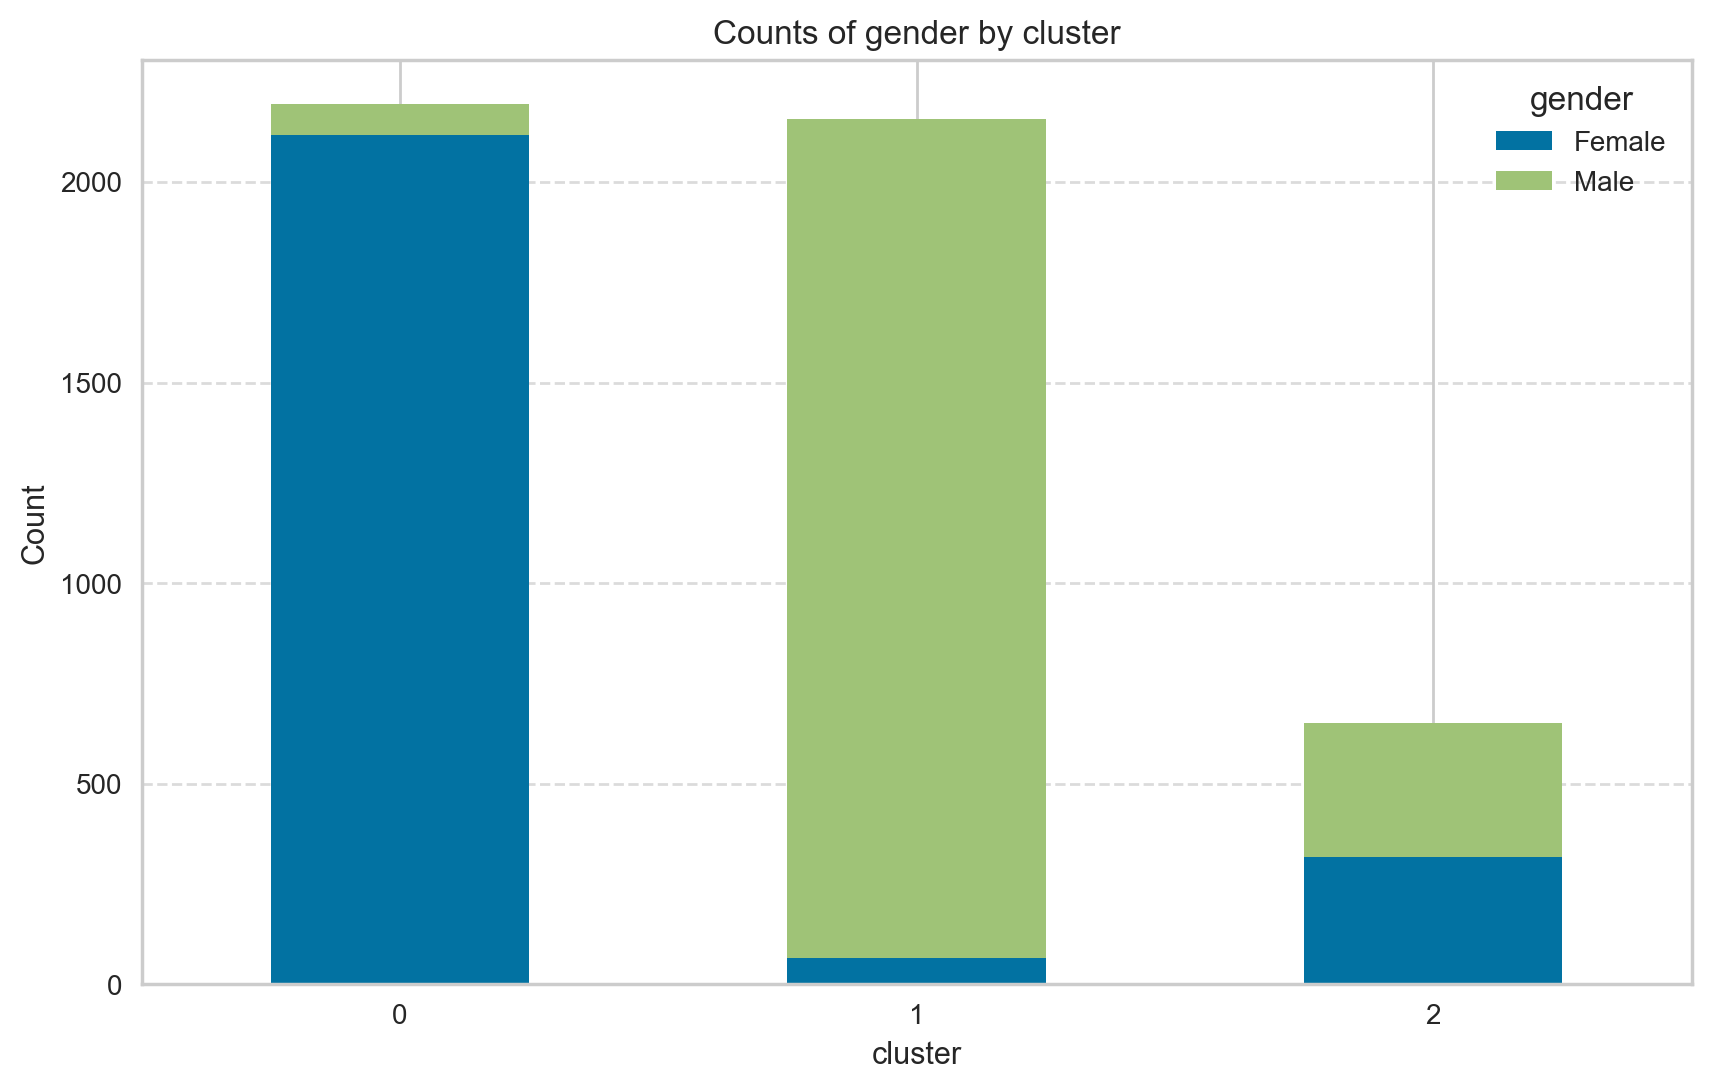

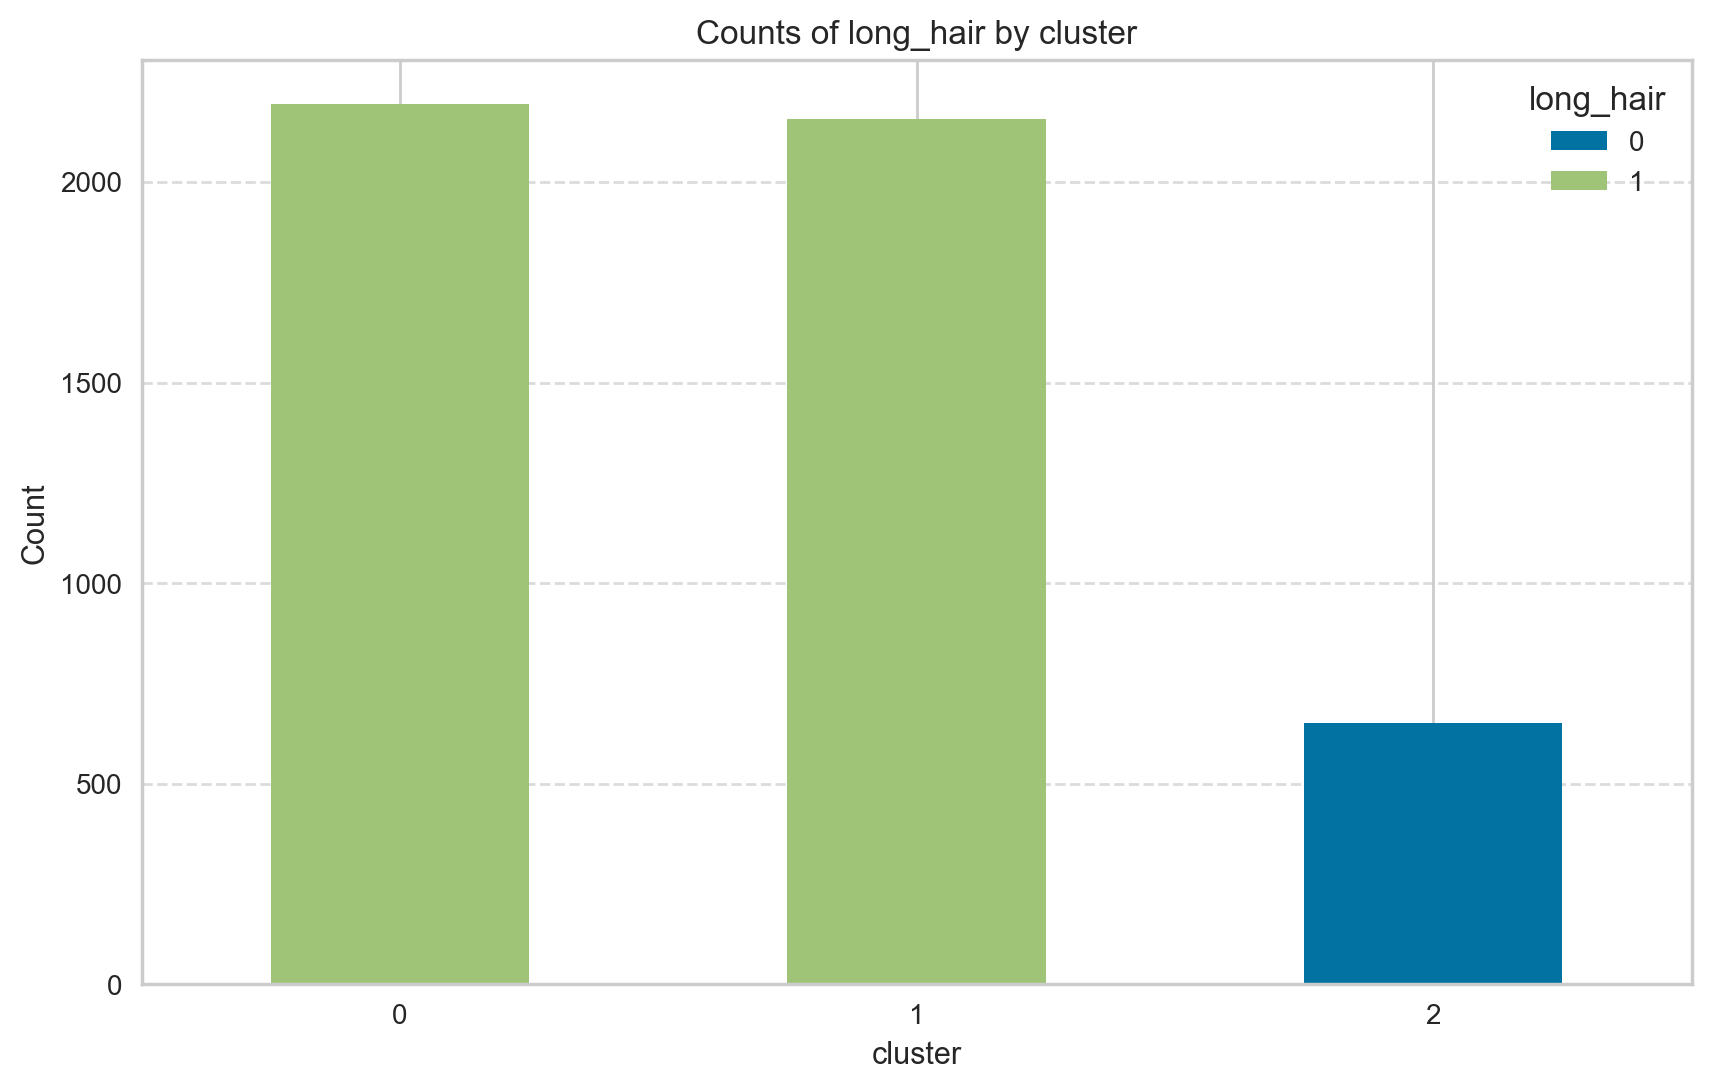

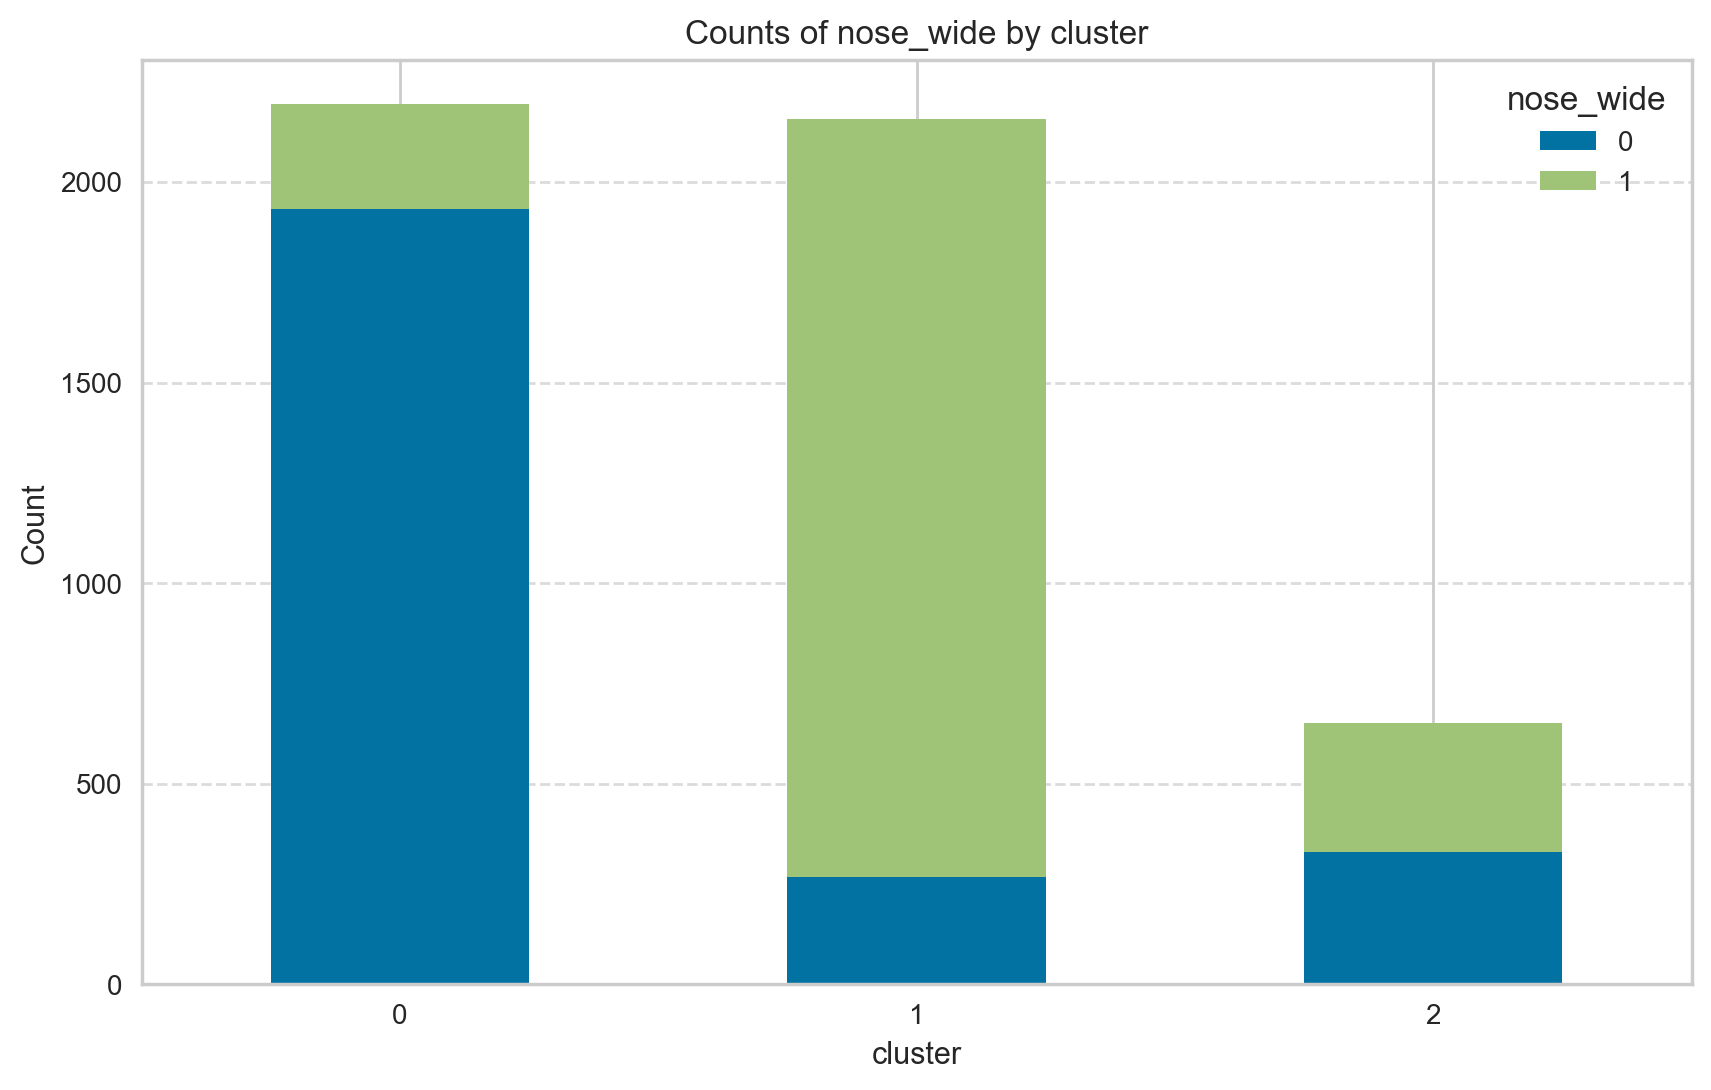

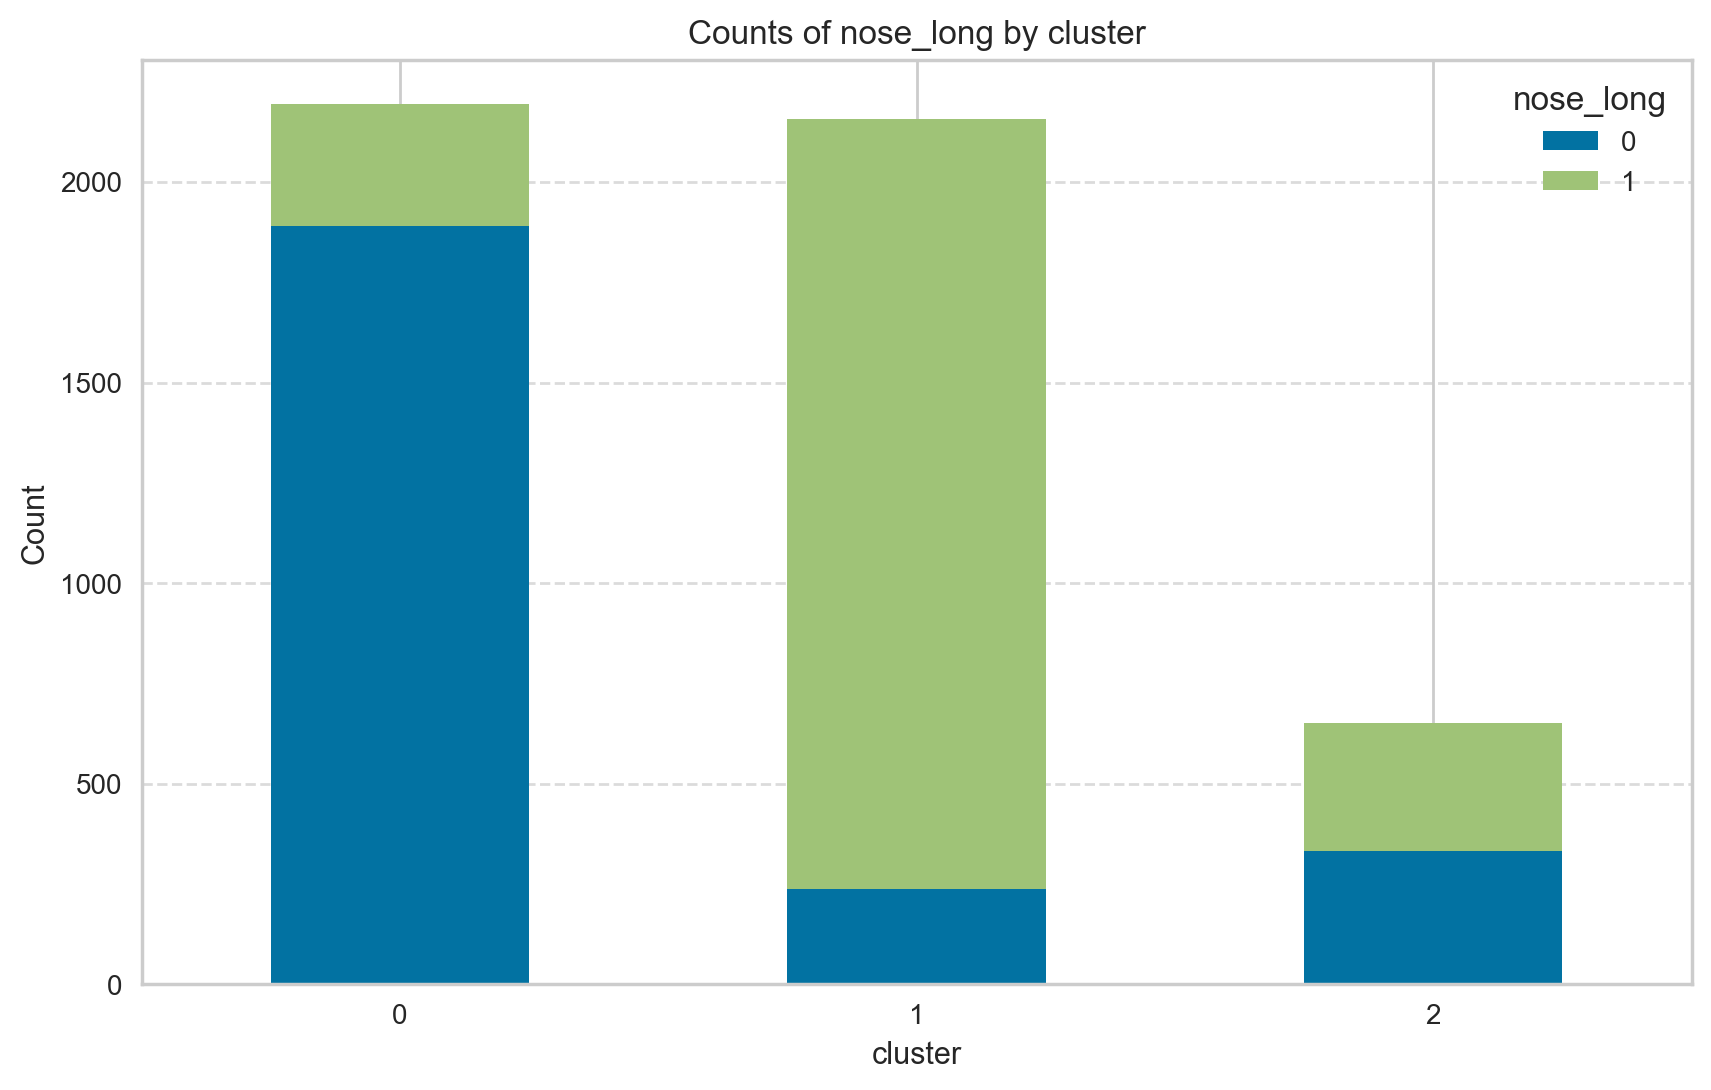

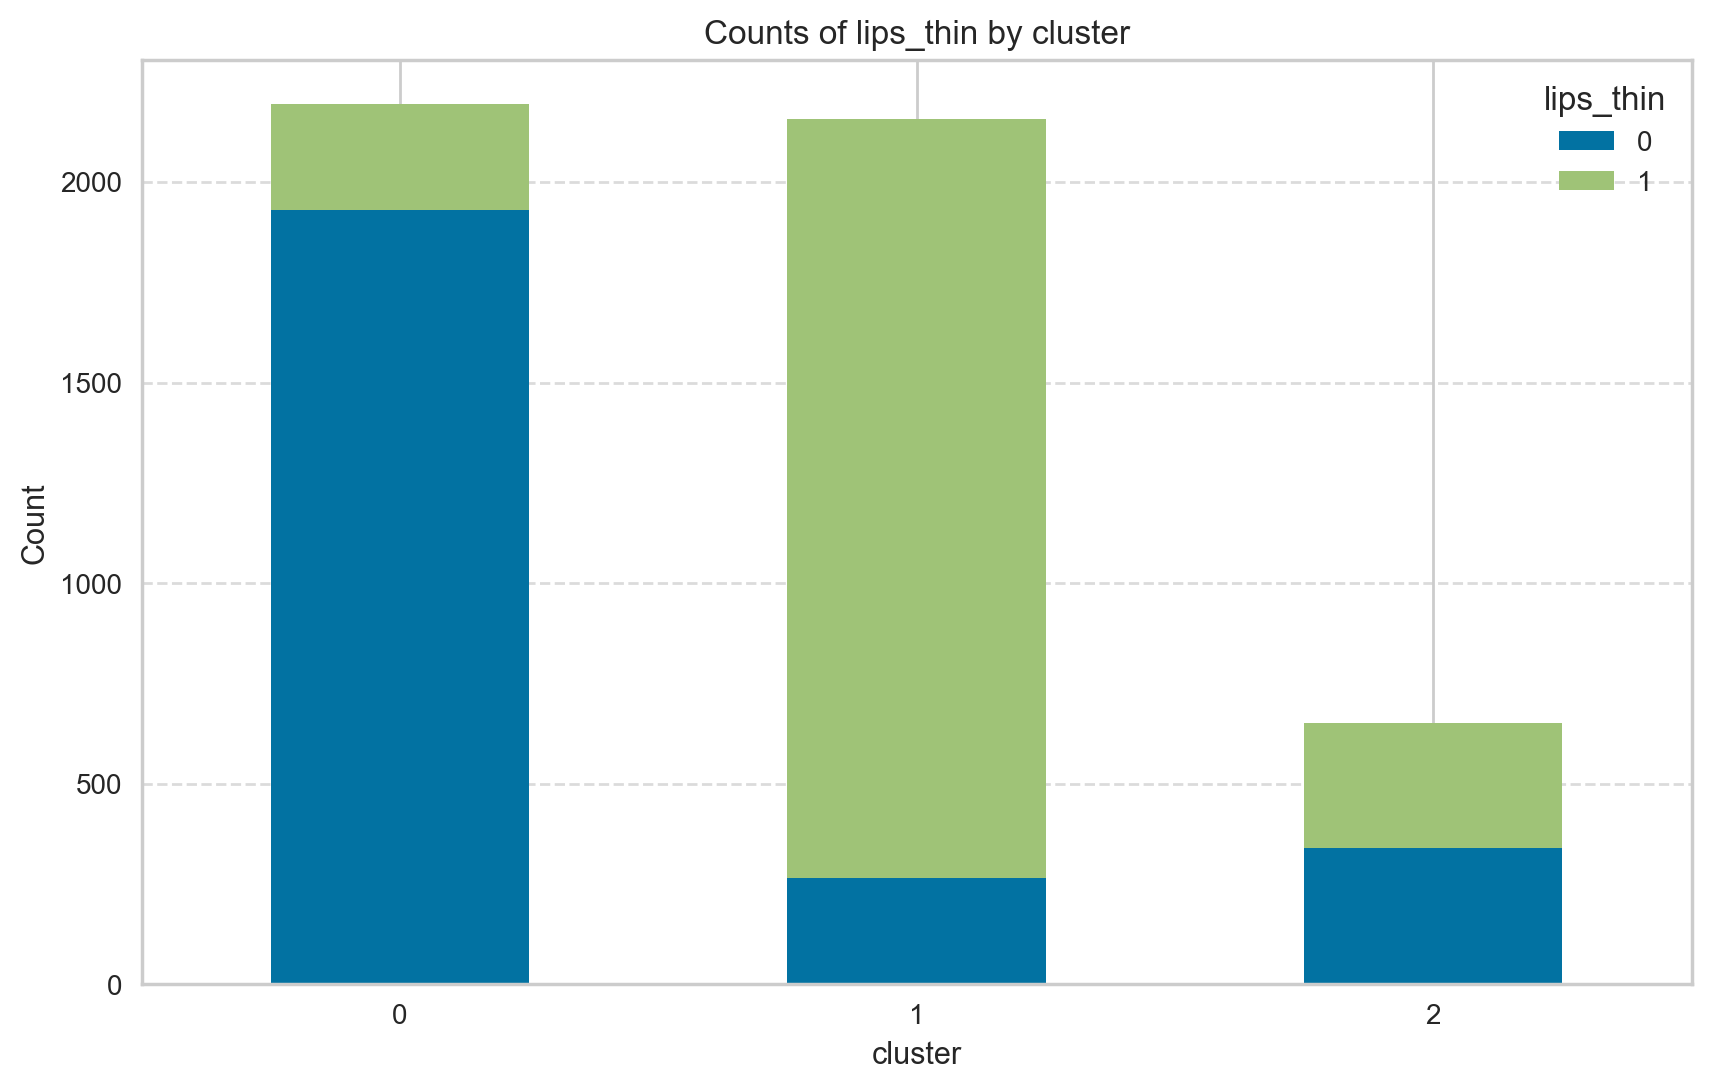

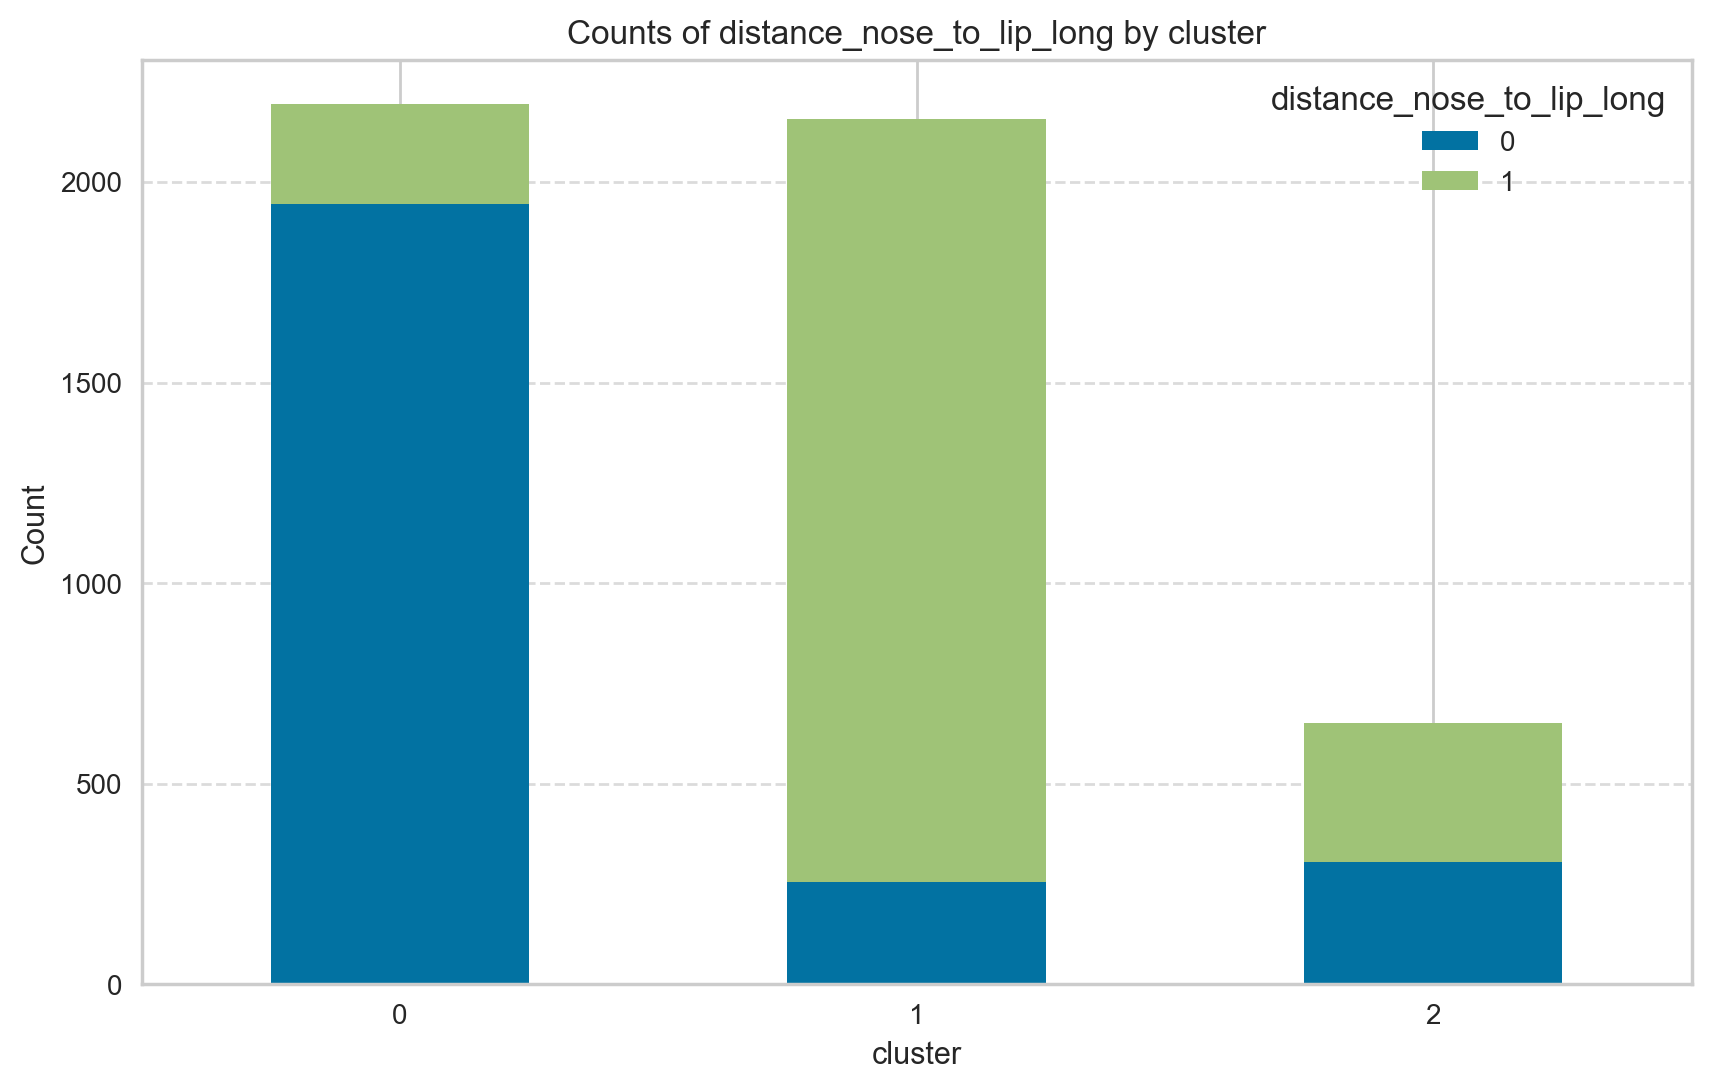

In [56]:
def plot_grouped_bar_chart(df, group_col, count_col, figsize=(10, 6)):
    """
    Plots a stacked bar chart showing counts of values in `count_col` grouped by `group_col`.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - group_col: column name to group by
    - count_col: column name whose values are counted
    - figsize: size of the figure (default is (10, 6))
    """
    # Group by the specified column and count occurrences
    counts = df.groupby([group_col, count_col]).size().unstack()
    
    # Plot the counts as a stacked bar chart
    counts.plot(kind='bar', stacked=True, figsize=figsize)
    
    # Customize the plot
    plt.title(f'Counts of {count_col} by {group_col}')
    plt.xlabel(group_col)
    plt.ylabel('Count')
    plt.legend(title=count_col)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.show()

col_name = ['gender', 'long_hair', 'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long']
for col in col_name:
    plot_grouped_bar_chart(df_combined1, 'cluster', col)

#### Analyse Gender - Hierarchical Clustering

In [59]:
df2 = pd.read_csv('gender.csv')

# Combine `df1` with `cluster_series` into a new DataFrame
df_combined2 = pd.concat([df2, df_with_agglomerative['cluster']], axis=1)

# Display the first few rows of the combined DataFrame
df_combined2.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender,cluster
0,1,11.8,6.1,1,0,1,1,Male,1
1,0,14.0,5.4,0,0,1,0,Female,3
2,0,11.8,6.3,1,1,1,1,Male,2
3,0,14.4,6.1,0,1,1,1,Male,2
4,1,13.5,5.9,0,0,0,0,Female,0


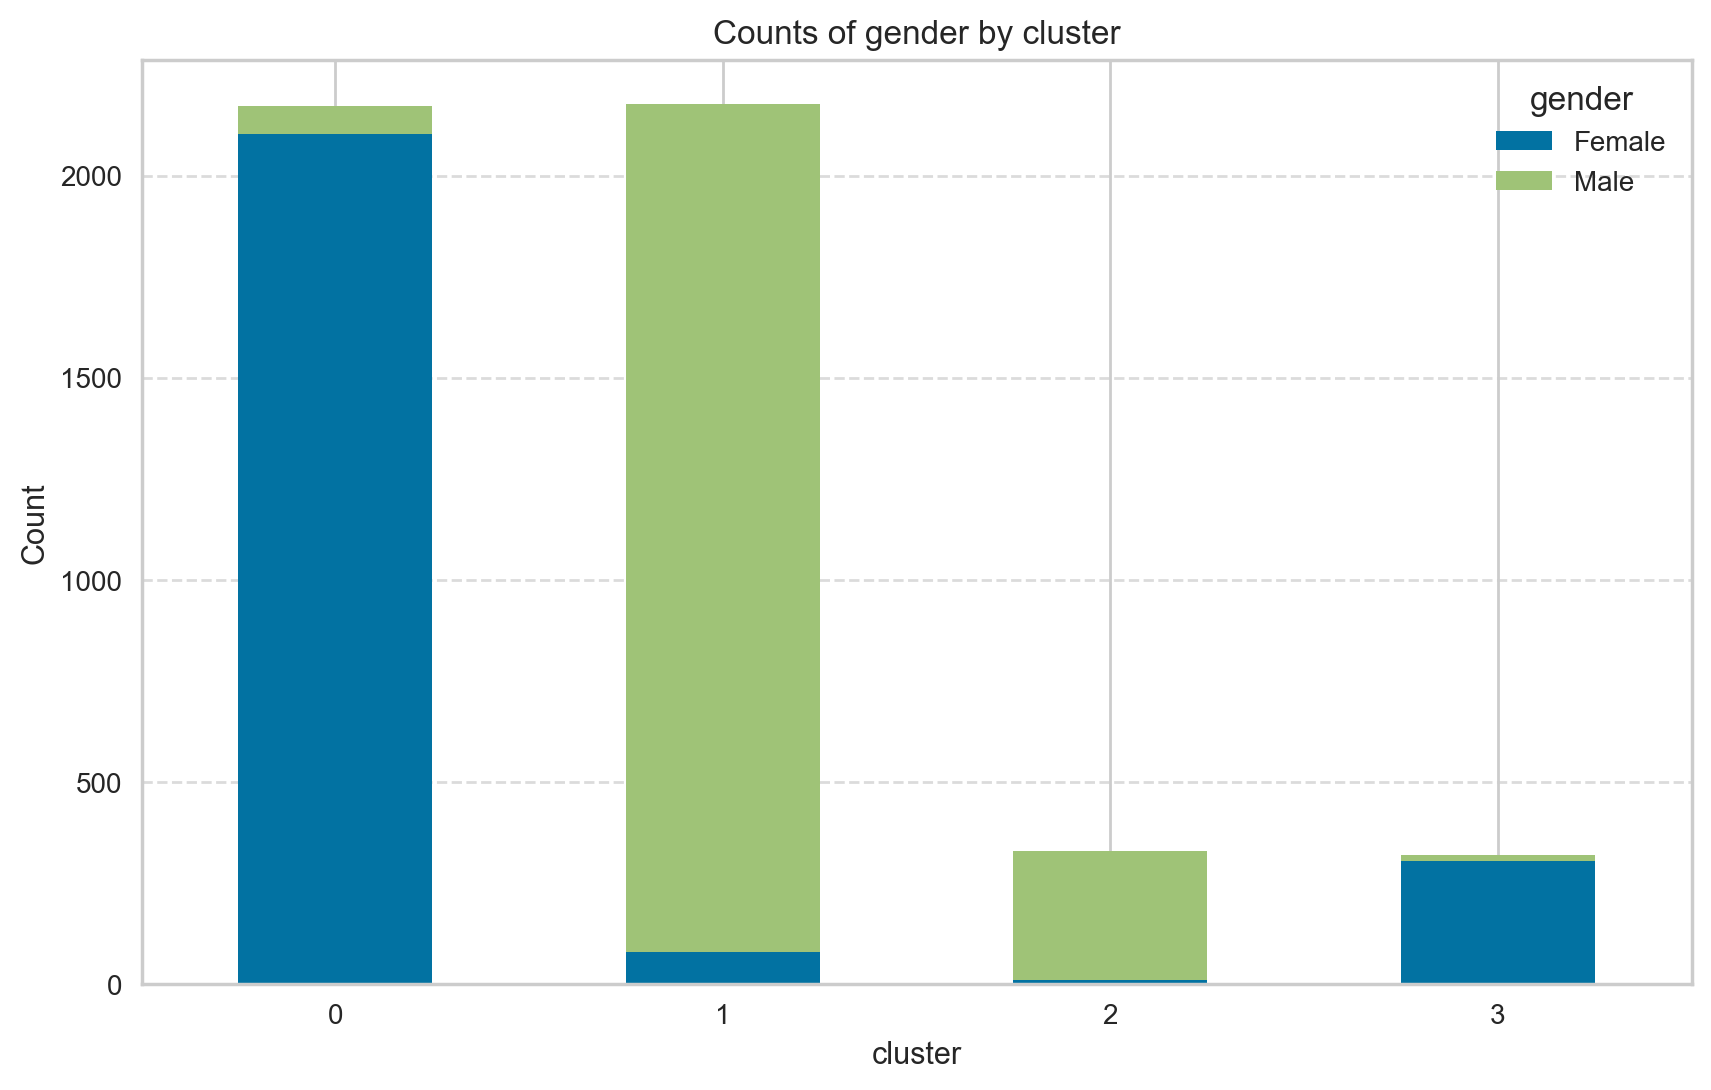

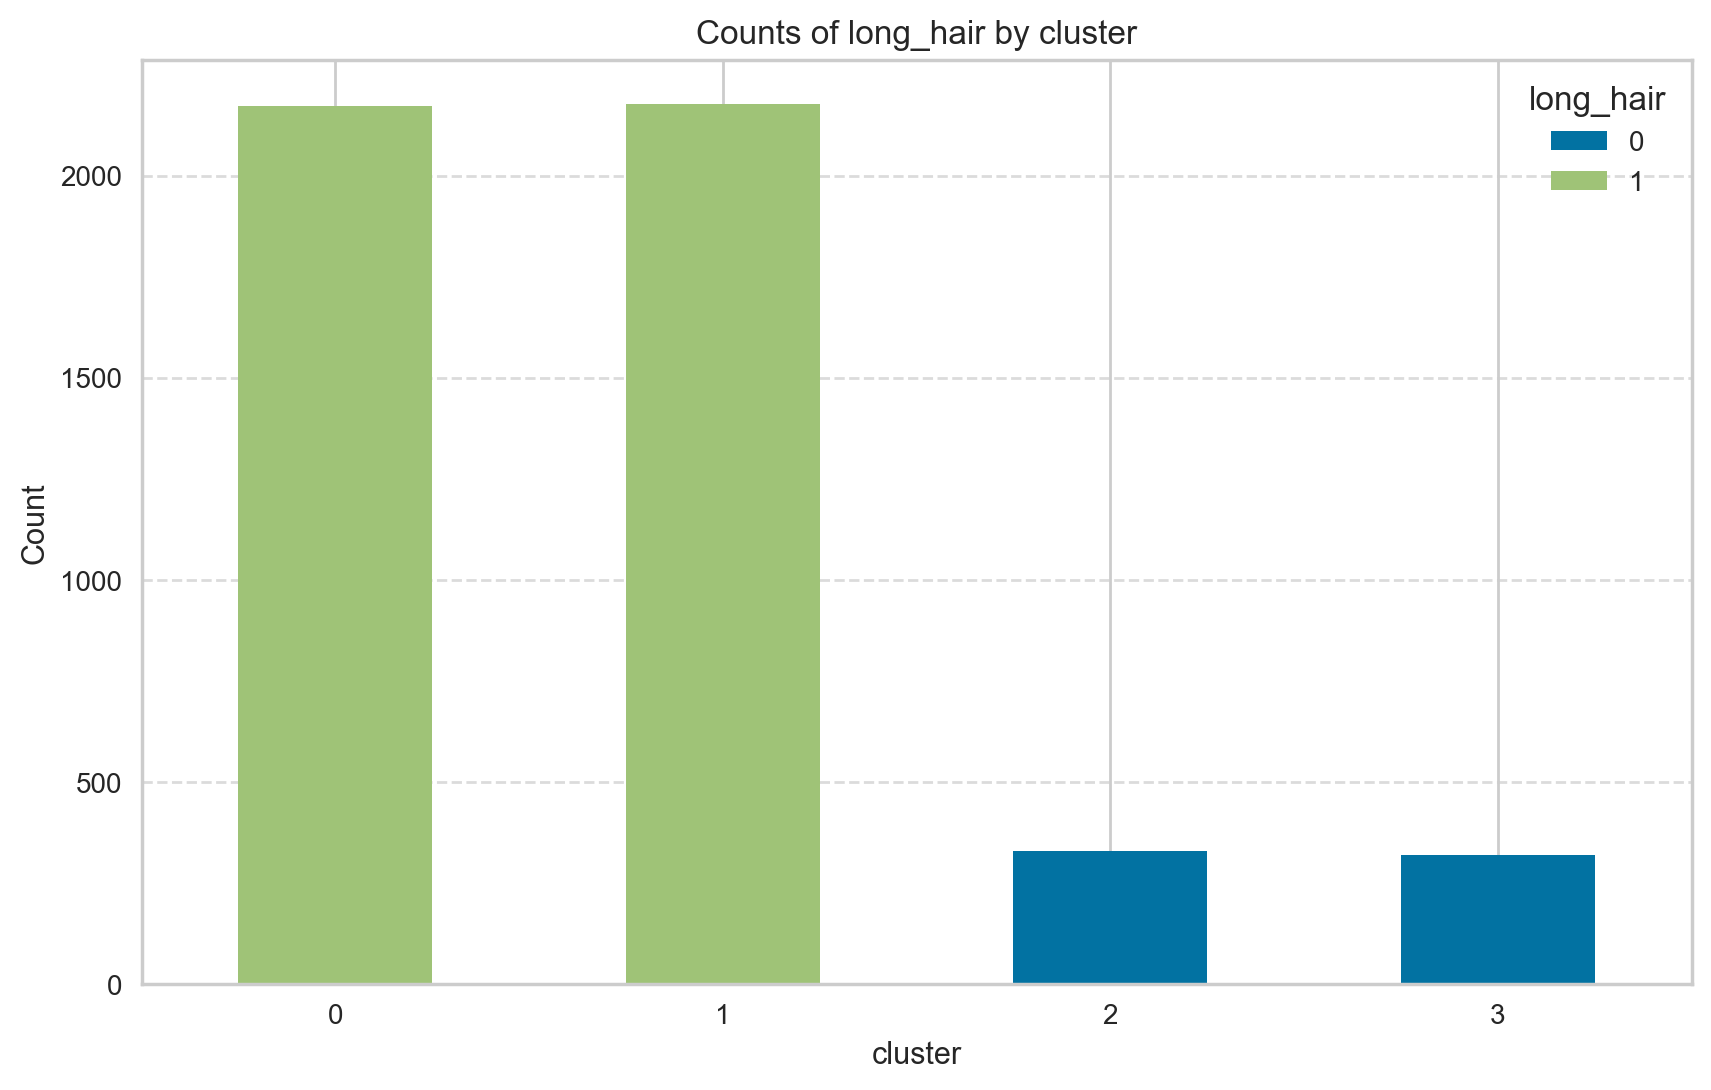

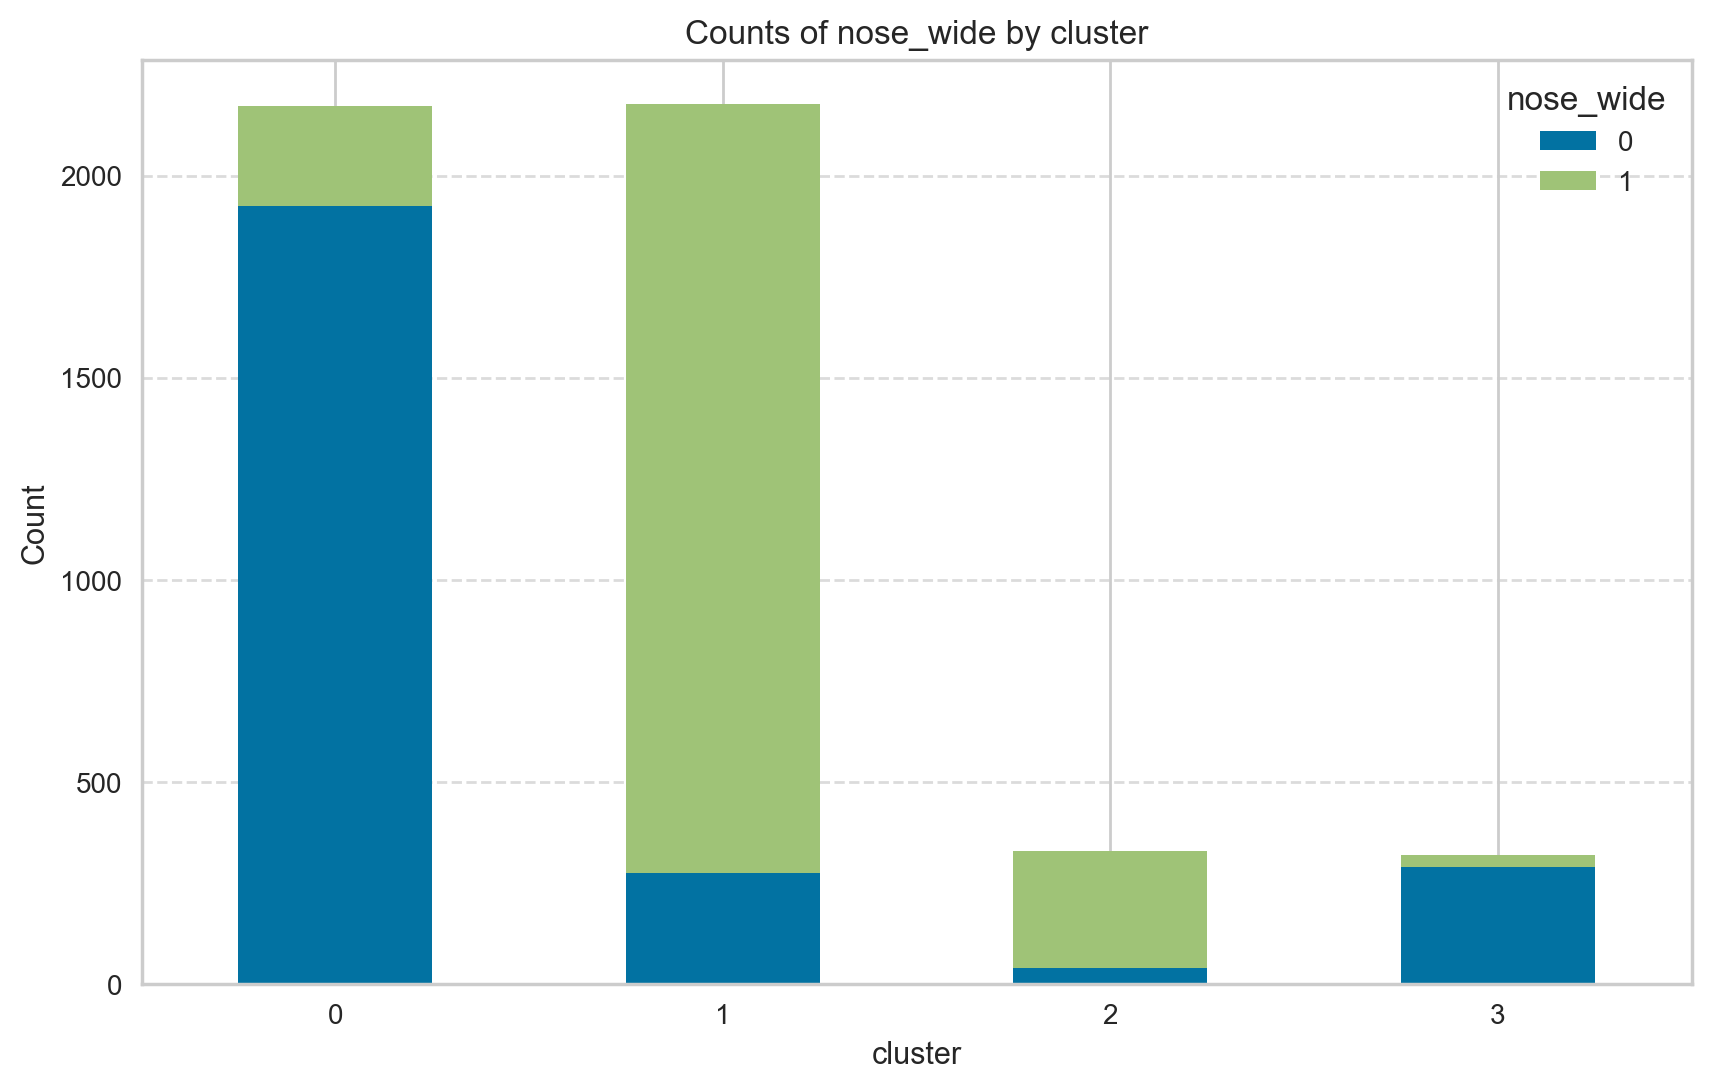

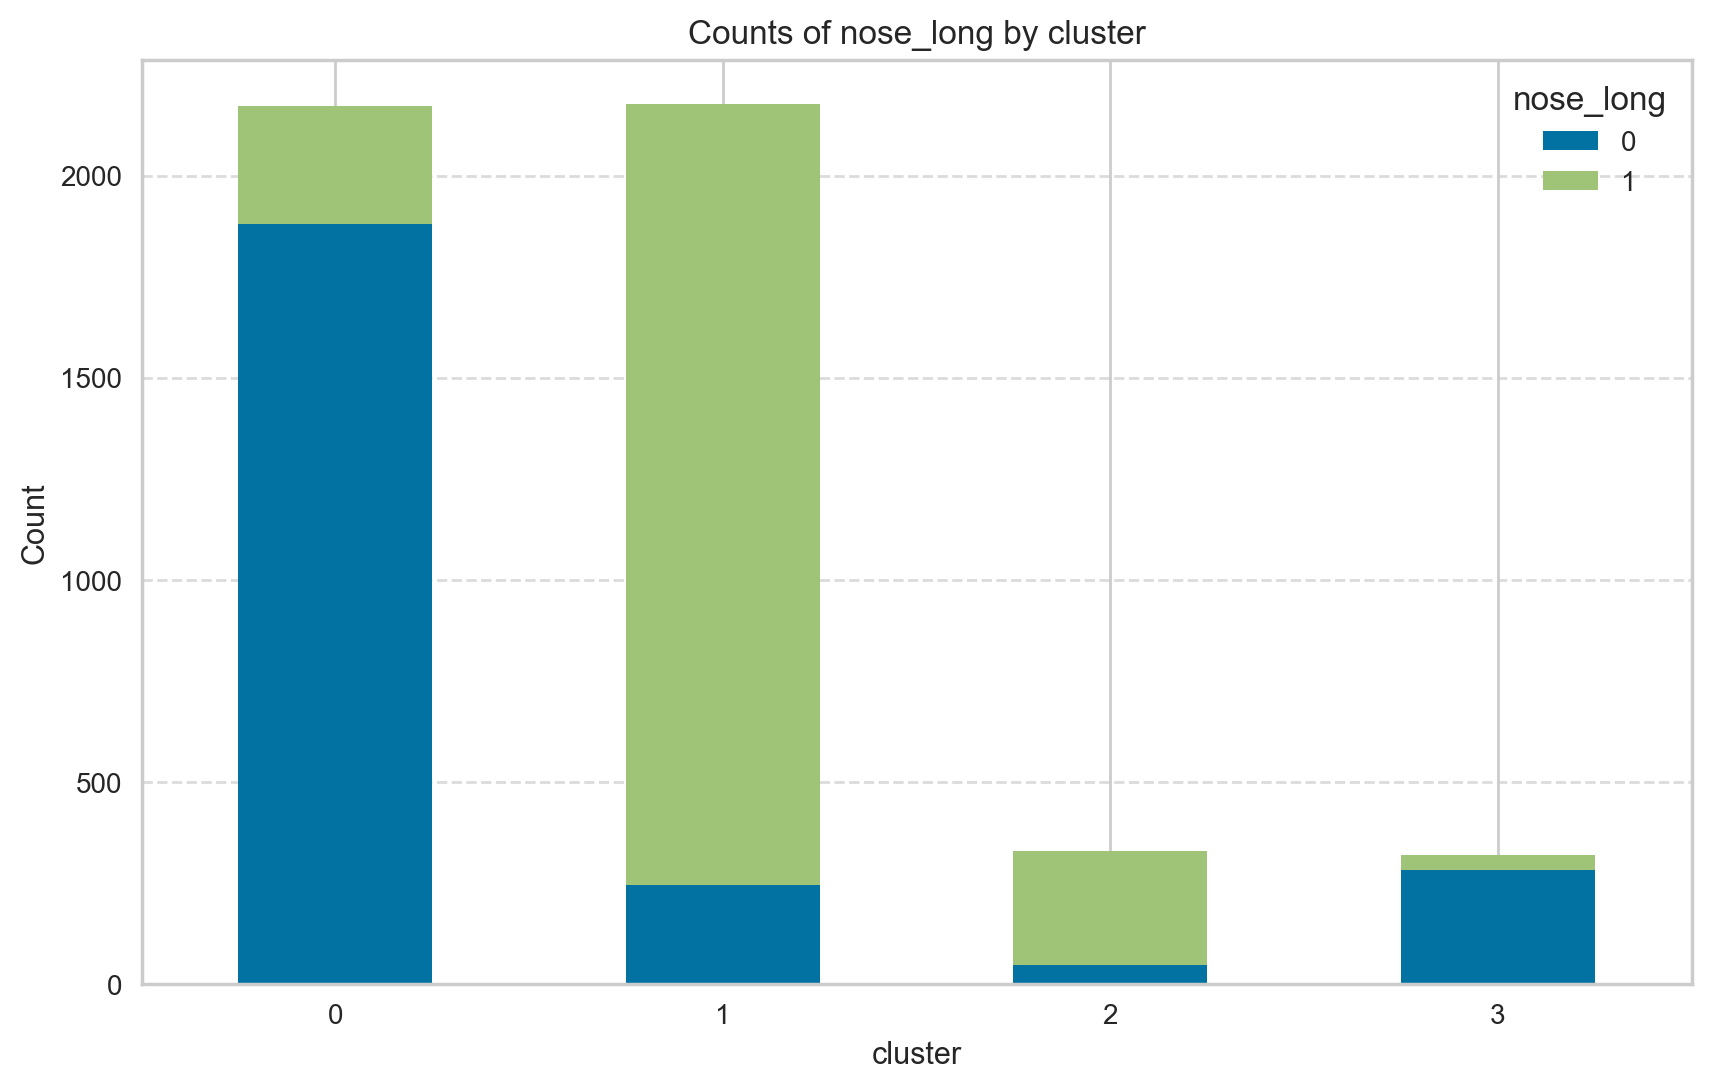

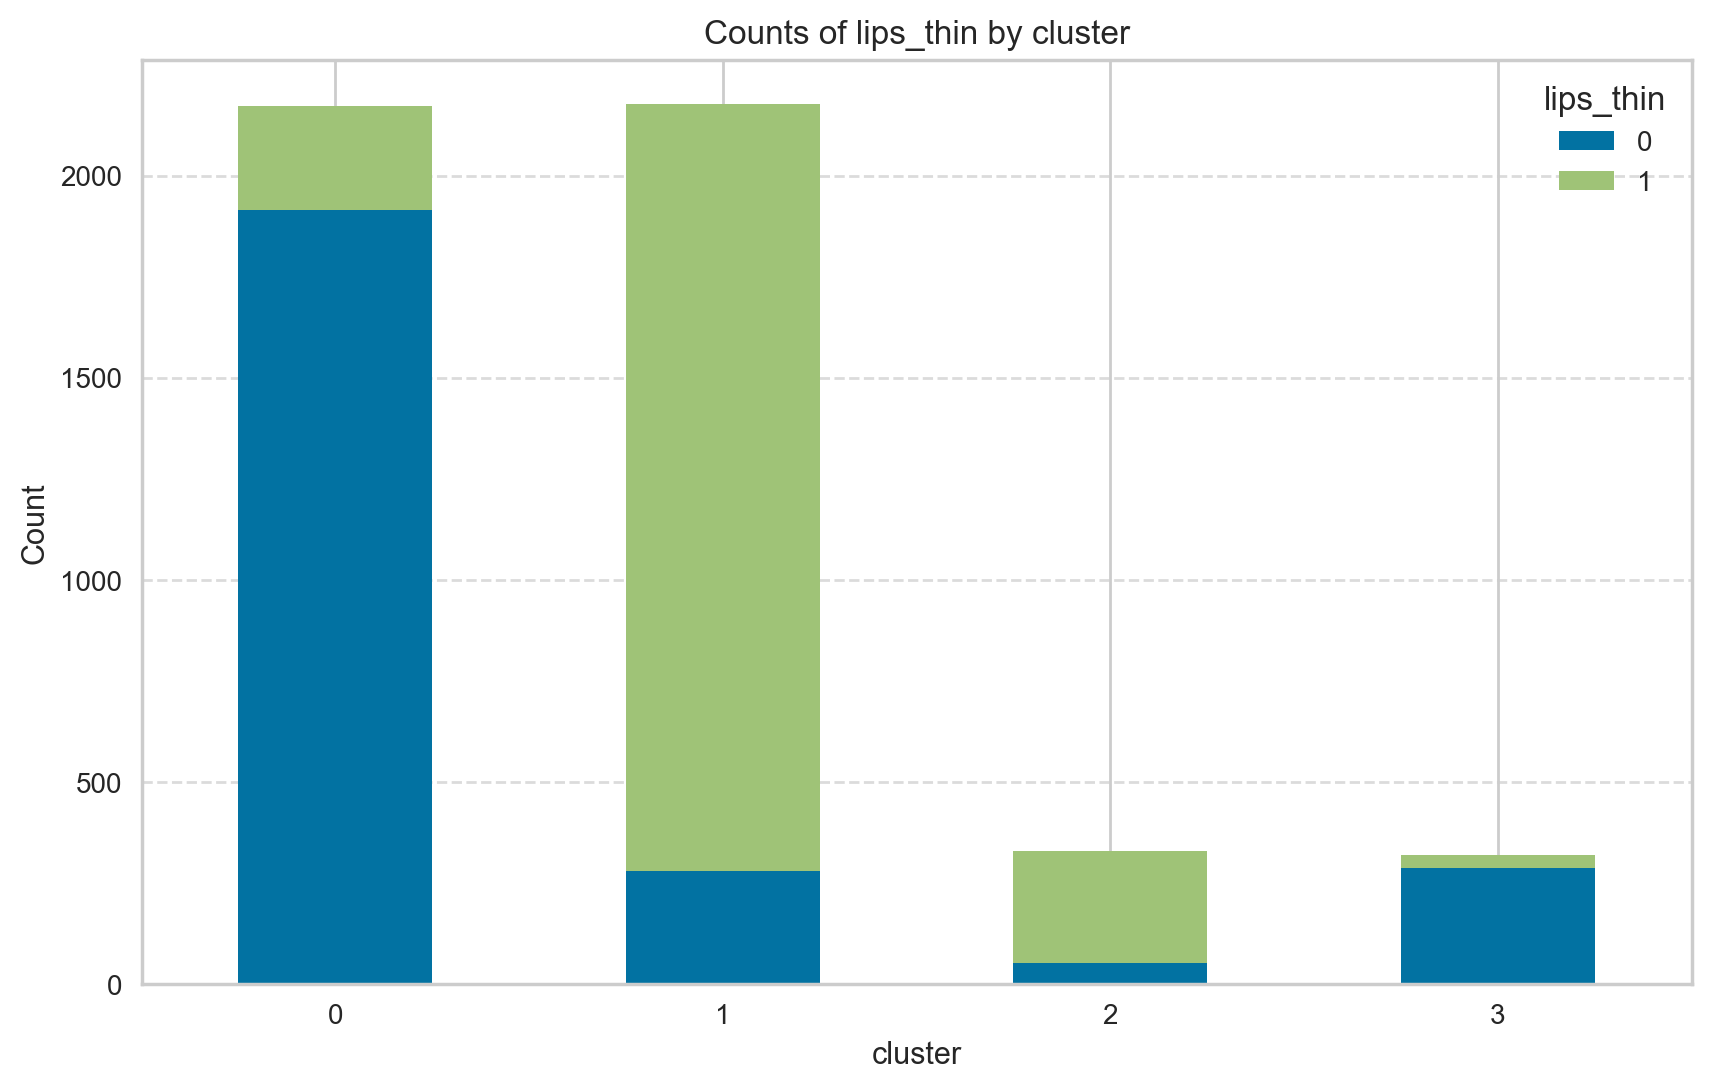

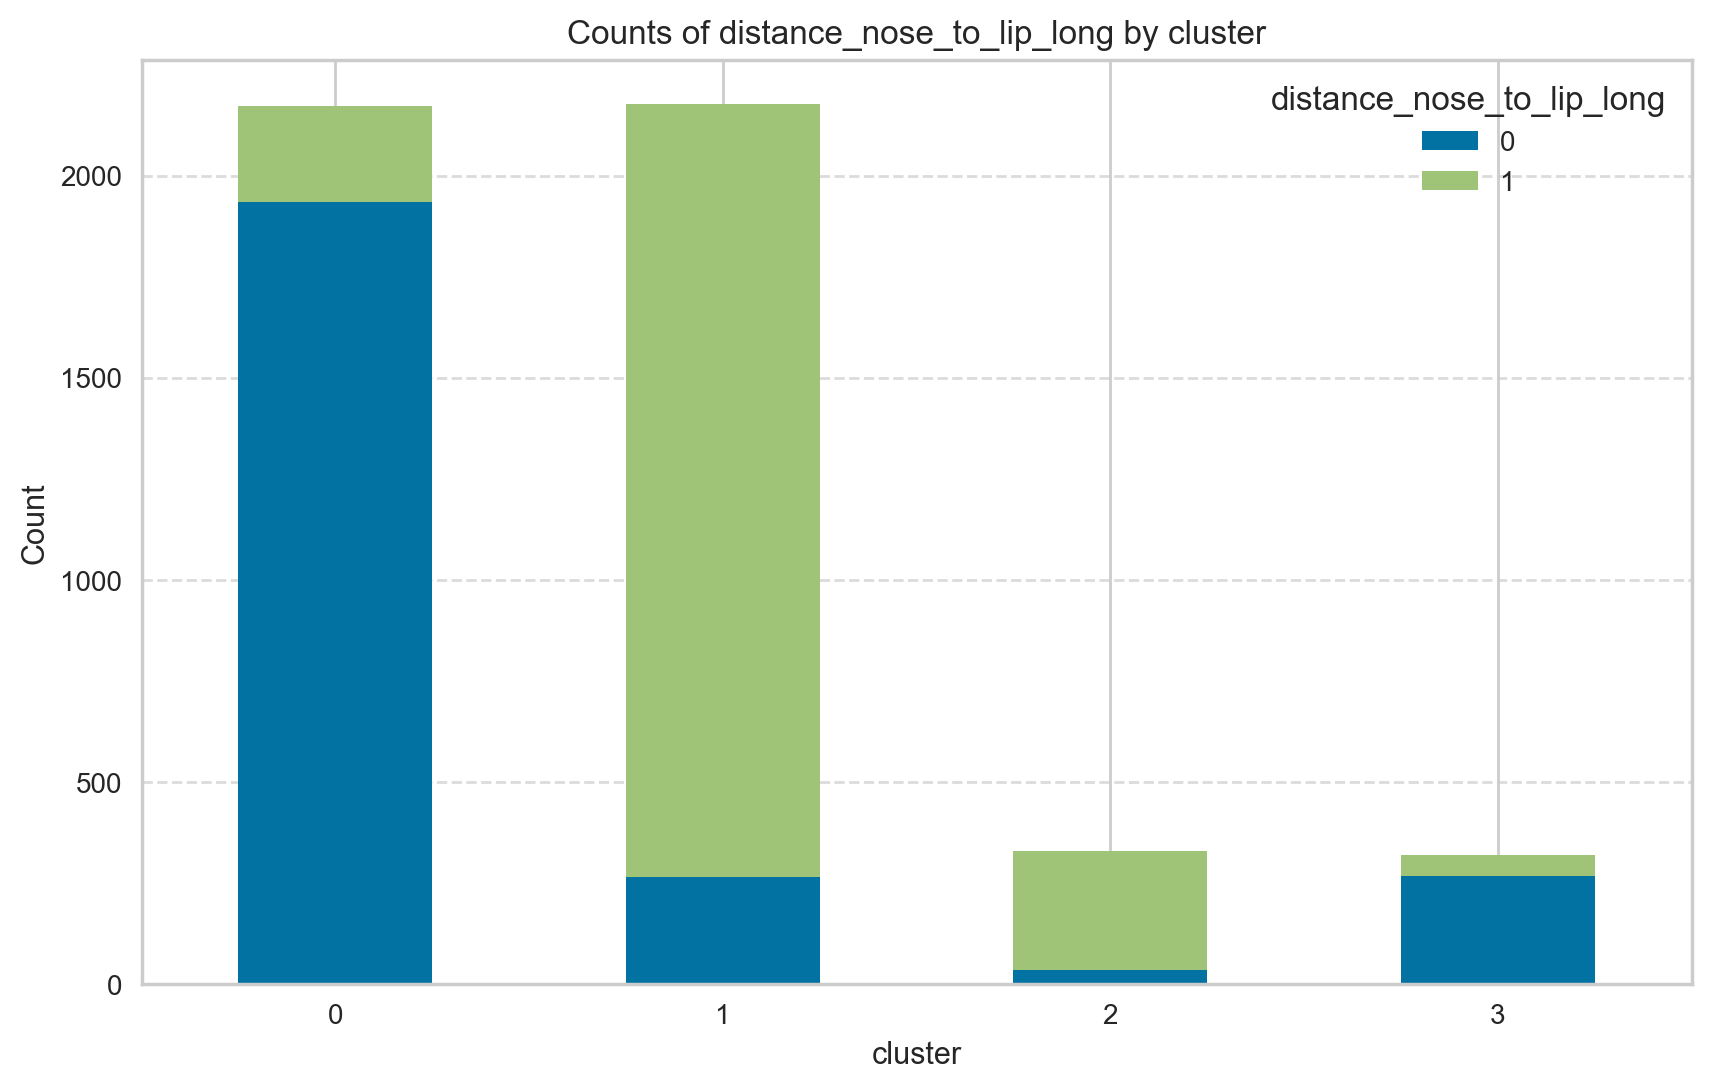

In [61]:
col_name = ['gender', 'long_hair', 'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long']
for col in col_name:
    plot_grouped_bar_chart(df_combined2, 'cluster', col)